# Cargar y parsear el XML del horario (timetable.xml)


In [11]:
!pip install xmltodict pandas matplotlib numpy


In [12]:
import xmltodict, json
import pandas as pd
import random, math
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from itertools import combinations

In [13]:
# ---------- Ajustes ----------
XML_PATH = "pu-fal07-llr.xml"
SLOT_MINUTES = 5          # UniTime: cada bloque aprox5 minutos
DIAS = ["Lunes","Martes","Miércoles","Jueves","Viernes","Sábado","Domingo"]

POP_SIZE = 50
GENERATIONS = 80
TOURNAMENT_K = 3
MUTATION_RATE = 0.15

In [14]:
# ---------- Helpers ----------
def to_hhmm_from_slot(slot):
    minutes = slot * SLOT_MINUTES
    h = minutes // 60
    m = minutes % 60
    return f"{h:02d}:{m:02d}"

def parse_days_bin(days_str):
    # days_str = "1010100" -> lista de nombres de dias activos
    return [DIAS[i] for i,ch in enumerate(days_str) if ch == "1"]

def time_overlaps(t1, t2):
    days1 = t1['days_bin']; days2 = t2['days_bin']
    if int(days1,2) & int(days2,2) == 0:
        return False
    s1 = t1['start']; e1 = s1 + t1['length']
    s2 = t2['start']; e2 = s2 + t2['length']
    return (s1 < e2) and (s2 < e1)

def pref_to_penalty(pref_raw):

    if pref_raw is None:
        return 0
    if pref_raw == "R":   # required: if violated -> huge penalty
        return 0
    if pref_raw == "P":   # prohibited: treat separately
        return 999999
    try:
        p = int(float(pref_raw))
    except:
        # If floats present, round
        try:
            p = int(round(float(pref_raw)))
        except:
            return 0
    # Map UniTime scale to numeric penalty
    mapping = { -2: 0, -1: 1, 0: 2, 1: 5, 2: 10 }
    return mapping.get(p, max(0, p*5))  # fallback

In [15]:
# ---------- Parse XML ----------
with open(XML_PATH, "r", encoding="utf-8") as f:
    data = xmltodict.parse(f.read())

rooms_raw = data['timetable']['rooms']['room']
classes_raw = data['timetable']['classes']['class']
constraints_raw = data['timetable'].get('groupConstraints', {}).get('constraint', [])
students_raw = data['timetable'].get('students', {}).get('student', [])

In [16]:
# Normalize singletons to lists
if isinstance(rooms_raw, dict): rooms_raw = [rooms_raw]
if isinstance(classes_raw, dict): classes_raw = [classes_raw]
if isinstance(constraints_raw, dict): constraints_raw = [constraints_raw]
if isinstance(students_raw, dict): students_raw = [students_raw]

# Rooms dict (id -> attrs)
rooms = {}
for r in rooms_raw:
    rid = r.get('@id')
    rooms[rid] = {
        'capacity': int(r.get('@capacity') or 0),
        'location': r.get('@location')
    }

# Classes: extraer room candidates y time candidates e instructor
classes = []   # list de diccionario
for c in classes_raw:
    cid = c.get('@id')
    # el instructor puede estar o no
    instr = None
    if isinstance(c.get('instructor'), list):
        instr = c['instructor'][0].get('@id')
    elif isinstance(c.get('instructor'), dict):
        instr = c['instructor'].get('@id')
    # rooms candidates:  list o dict
    room_nodes = c.get('room', [])
    if isinstance(room_nodes, dict):
        room_nodes = [room_nodes]
    room_cands = []
    for rn in room_nodes:
        if rn is None: continue
        rid = rn.get('@id')
        pref = rn.get('@pref')
        sol = rn.get('@solution')
        room_cands.append({'id': rid, 'pref': pref, 'solution': sol == "true"})
    # time candidates inside class
    time_nodes = c.get('time', [])
    if isinstance(time_nodes, dict):
        time_nodes = [time_nodes]
    time_cands = []
    for tn in time_nodes:
        if tn is None: continue
        days_bin = tn.get('@days', "0000000")
        start = int(tn.get('@start', 0))
        length = int(tn.get('@length', 0))
        pref = tn.get('@pref')
        sol = tn.get('@solution')
        time_cands.append({
            'days_bin': days_bin,
            'dias': parse_days_bin(days_bin),
            'start': start,
            'length': length,
            'start_hhmm': to_hhmm_from_slot(start),
            'end_hhmm': to_hhmm_from_slot(start + length),
            'pref': pref,
            'solution': sol == "true"
        })
    classes.append({
        'id': cid,
        'offering': c.get('@offering'),
        'classLimit': int(c.get('@classLimit') or 0),
        'instructor': instr,
        'room_cands': room_cands,
        'time_cands': time_cands,
        'committed': c.get('@committed') == "true"
    })

# Students: map student -> classes y weights
student_enrol = {}
for s in students_raw:
    sid = s.get('@id')
    weight = 1.0
    offers = s.get('offering', [])
    if isinstance(offers, dict):
        offers = [offers]
    for o in offers:
        if o is not None and '@weight' in o:
            try:
                weight = float(o['@weight'])
            except:
                pass
    cls = []
    cls_nodes = s.get('class', [])
    if isinstance(cls_nodes, dict):
        cls_nodes = [cls_nodes]
    for cn in cls_nodes:
        if cn is None: continue
        cls.append(cn.get('@id'))
    prohibited = []
    p_nodes = s.get('prohibited-class', [])
    if isinstance(p_nodes, dict):
        p_nodes = [p_nodes]
    for pn in p_nodes:
        if pn is None: continue
        prohibited.append(pn.get('@id'))
    student_enrol[sid] = {'weight': weight, 'classes': cls, 'prohibited': prohibited}

# Build map class -> students list
class_to_students = defaultdict(list)
for sid, info in student_enrol.items():
    for cid in info['classes']:
        class_to_students[cid].append((sid, info['weight']))

In [17]:
# ---------- Simple GA  ----------
#selecciones permitidas por class:
allowed_rooms = { c['id']: [r['id'] for r in c['room_cands'] if r and r.get('id')] for c in classes }
allowed_times = { c['id']: [i for i in range(len(c['time_cands']))] for c in classes }  # index into time_cands

def generate_individual():
    ind = {}
    for c in classes:
        cid = c['id']
        rlist = allowed_rooms[cid]
        tlist = allowed_times[cid]
        if not rlist or not tlist:
            # No candidato
            ind[cid] = {'room': None, 'time_idx': None}
        else:
            ind[cid] = {'room': random.choice(rlist), 'time_idx': random.choice(tlist)}
    return ind

def fitness(ind):
    # Mas bajo es mejor (penalty)
    penalty = 0
    # conjunto de conflictos dificiles
    occupied = defaultdict(list)  # key: (room, day_bit, slot-range) store class ids
    instr_sched = defaultdict(list)  # instr -> list of (time_dict, cid)
    # conflicto de estudiantes
    # Mapa de información de ubicación de construcción
    placement = {}
    for c in classes:
        cid = c['id']
        pick = ind.get(cid)
        if pick is None or pick['room'] is None or pick['time_idx'] is None:
            penalty += 1000  # dura penalidad por unassigned
            continue
        room = pick['room']
        time_obj = c['time_cands'][ pick['time_idx'] ]
        placement[cid] = {'room': room, 'time': time_obj, 'instructor': c['instructor']}
        # Clave de ocupación de habitación/tiempo: consultar por día
        for i,bit in enumerate(time_obj['days_bin']):
            if bit == '1':
                daybit = 1<<i
                occupied[(room, i)].append((time_obj['start'], time_obj['length'], cid))
        # instructor
        if c['instructor']:
            instr_sched[c['instructor']].append((time_obj, cid))
    # revisar room overlaps
    for (room, day), lst in occupied.items():
        # comparar todos los pares
        for a,b in combinations(lst,2):
            s1,l1,c1 = a
            s2,l2,c2 = b
            if (s1 < s2 + l2) and (s2 < s1 + l1):
                penalty += 100  # hard
    # revisar instructor overlaps
    for instr, lst in instr_sched.items():
        for a,b in combinations(lst,2):
            t1, c1 = a; t2, c2 = b
            if time_overlaps(t1, t2):
                penalty += 1000
    # revisar student overlaps
    # por cada estudiante revisar su peso y su clase
    for sid, info in student_enrol.items():
        sclasses = info['classes']
        sweight = info['weight']

        for a,b in combinations(sclasses,2):
            if a in placement and b in placement:
                if time_overlaps(placement[a]['time'], placement[b]['time']):
                    penalty += 500 * sweight
    # prefs: room y time preferences
    for c in classes:
        cid = c['id']
        pick = ind.get(cid)
        if not pick or not pick['room'] or pick['time_idx'] is None: continue
        # room pref find raw
        room_nodes = c['room_cands']
        r_pref_raw = None
        for rn in room_nodes:
            if rn['id'] == pick['room']:
                r_pref_raw = rn.get('pref')
                break
        time_obj = c['time_cands'][ pick['time_idx'] ]
        t_pref_raw = time_obj.get('pref')
        # Hard R/P handling
        if r_pref_raw == 'P' or t_pref_raw == 'P':
            penalty += 1000000
        if r_pref_raw == 'R' or t_pref_raw == 'R':
            pass
        penalty += pref_to_penalty(r_pref_raw)
        penalty += pref_to_penalty(t_pref_raw)
    return penalty

# ---------- GA operators ----------
def tournament_select(pop, k=TOURNAMENT_K):
    contestants = random.sample(pop, k)
    return min(contestants, key=lambda ind: fitness(ind))

def crossover(p1, p2):
    child = {}
    for cid in p1:
        # elegir de un padre
        child[cid] = random.choice([p1[cid], p2[cid]]).copy()
    return child

def mutate(ind):
    for cid in ind:
        if random.random() < MUTATION_RATE:
            rlist = allowed_rooms[cid]
            if rlist:
                ind[cid]['room'] = random.choice(rlist)
        if random.random() < MUTATION_RATE:
            tlist = allowed_times[cid]
            if tlist:
                ind[cid]['time_idx'] = random.choice(tlist)
    return ind

def build_placement(ind):
    placement = {}
    for c in classes:
        cid = c['id']
        pick = ind.get(cid)
        if pick is None or pick['room'] is None or pick['time_idx'] is None:
            continue
        room = pick['room']
        time_obj = c['time_cands'][pick['time_idx']]
        placement[cid] = {'room': room, 'time': time_obj, 'instructor': c['instructor']}
    return placement


# ---------- Run un pequenio GA ----------
pop = [generate_individual() for _ in range(POP_SIZE)]
best = None
best_score = 1e18
for gen in range(GENERATIONS):
    pop_sorted = sorted(pop, key=lambda ind: fitness(ind))
    if fitness(pop_sorted[0]) < best_score:
        best = pop_sorted[0]
        best_score = fitness(pop_sorted[0])
    # Elitism: mantener top 2
    new_pop = pop_sorted[:2]
    while len(new_pop) < POP_SIZE:
        p1 = tournament_select(pop)
        p2 = tournament_select(pop)
        child = crossover(p1,p2)
        child = mutate(child)
        new_pop.append(child)
    pop = new_pop
    if gen % 5 == 0 or gen == GENERATIONS-1:
        print(f"Gen {gen} best fitness: {best_score:.2f}")

print("Mejor fitness final:", best_score)



Gen 0 best fitness: 111460.00
Gen 5 best fitness: 100399.00
Gen 10 best fitness: 100399.00
Gen 15 best fitness: 98005.00
Gen 20 best fitness: 98005.00
Gen 25 best fitness: 94346.00
Gen 30 best fitness: 94286.00
Gen 35 best fitness: 94286.00
Gen 40 best fitness: 94286.00
Gen 45 best fitness: 94286.00
Gen 50 best fitness: 94286.00
Gen 55 best fitness: 93524.00
Gen 60 best fitness: 93524.00
Gen 65 best fitness: 93524.00
Gen 70 best fitness: 93524.00
Gen 75 best fitness: 93524.00
Gen 79 best fitness: 93524.00
Mejor fitness final: 93524


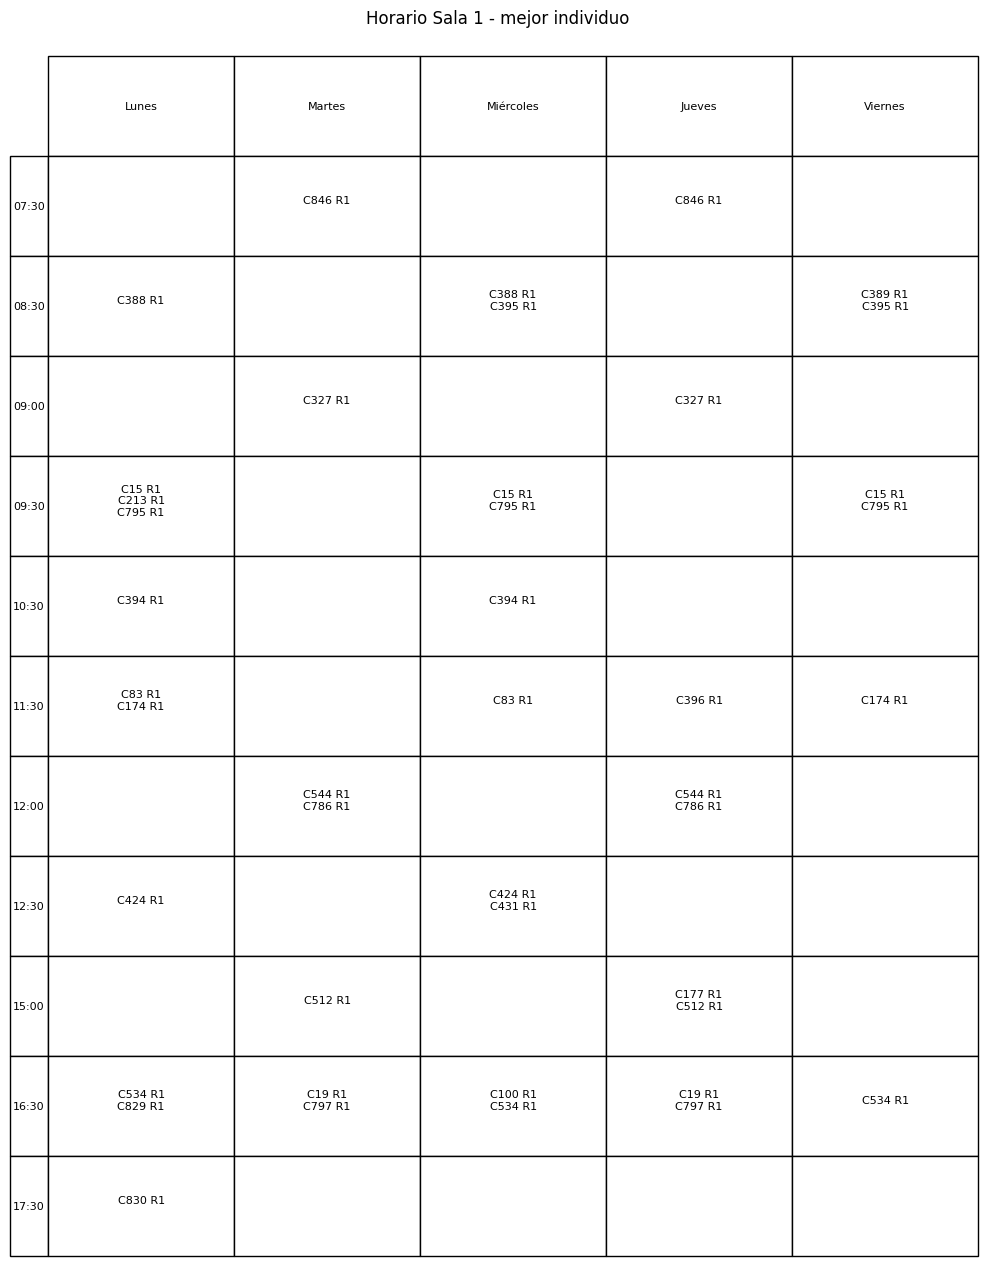

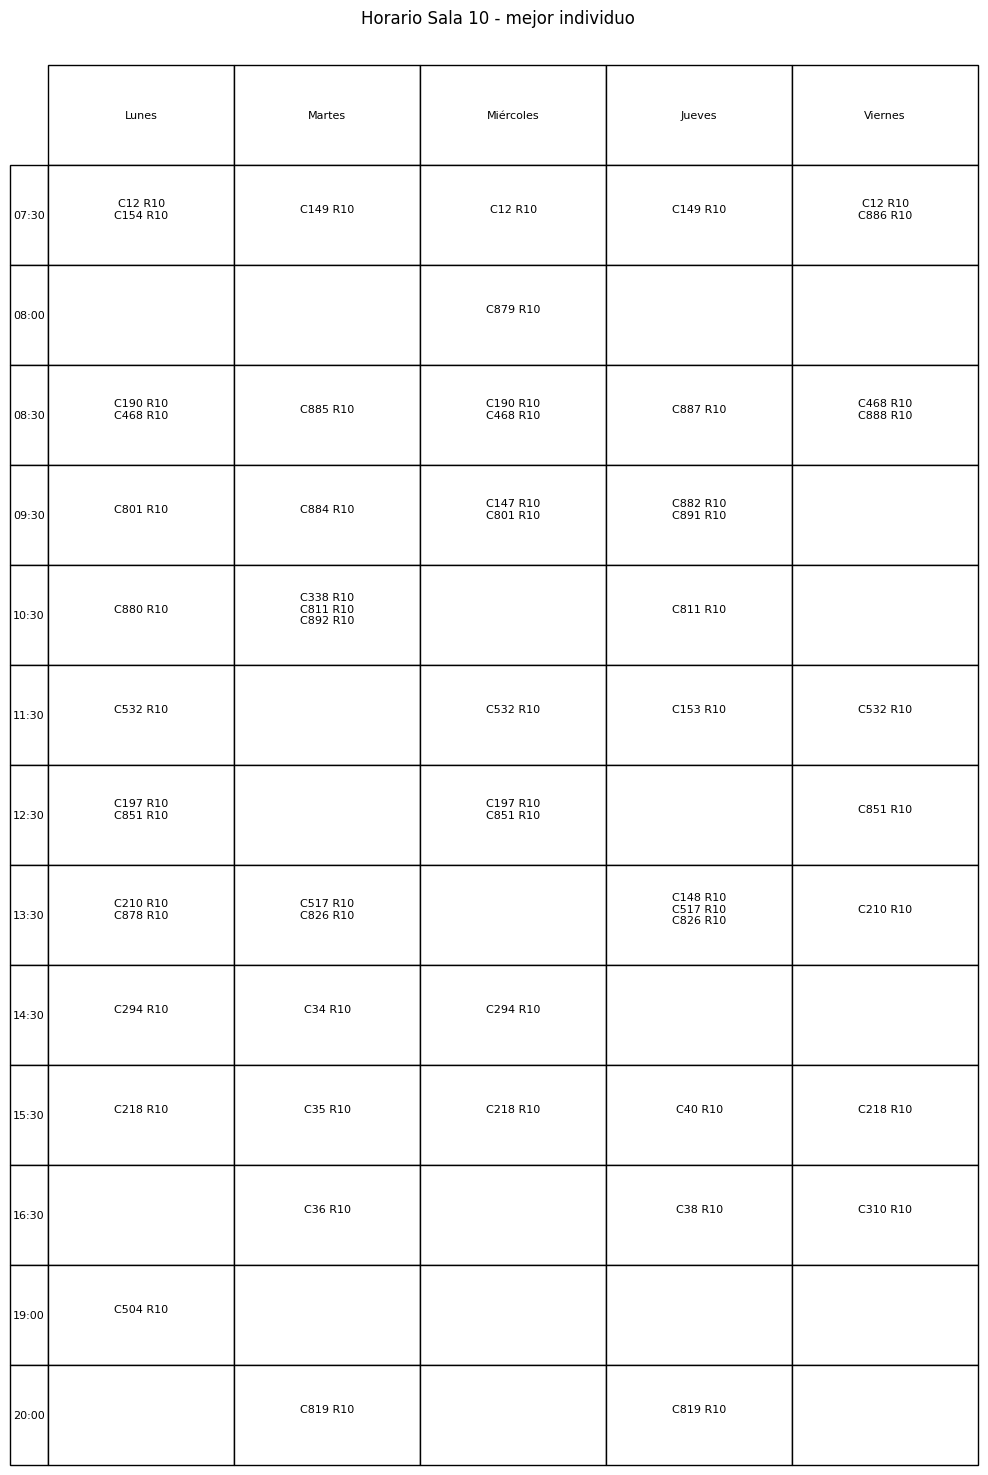

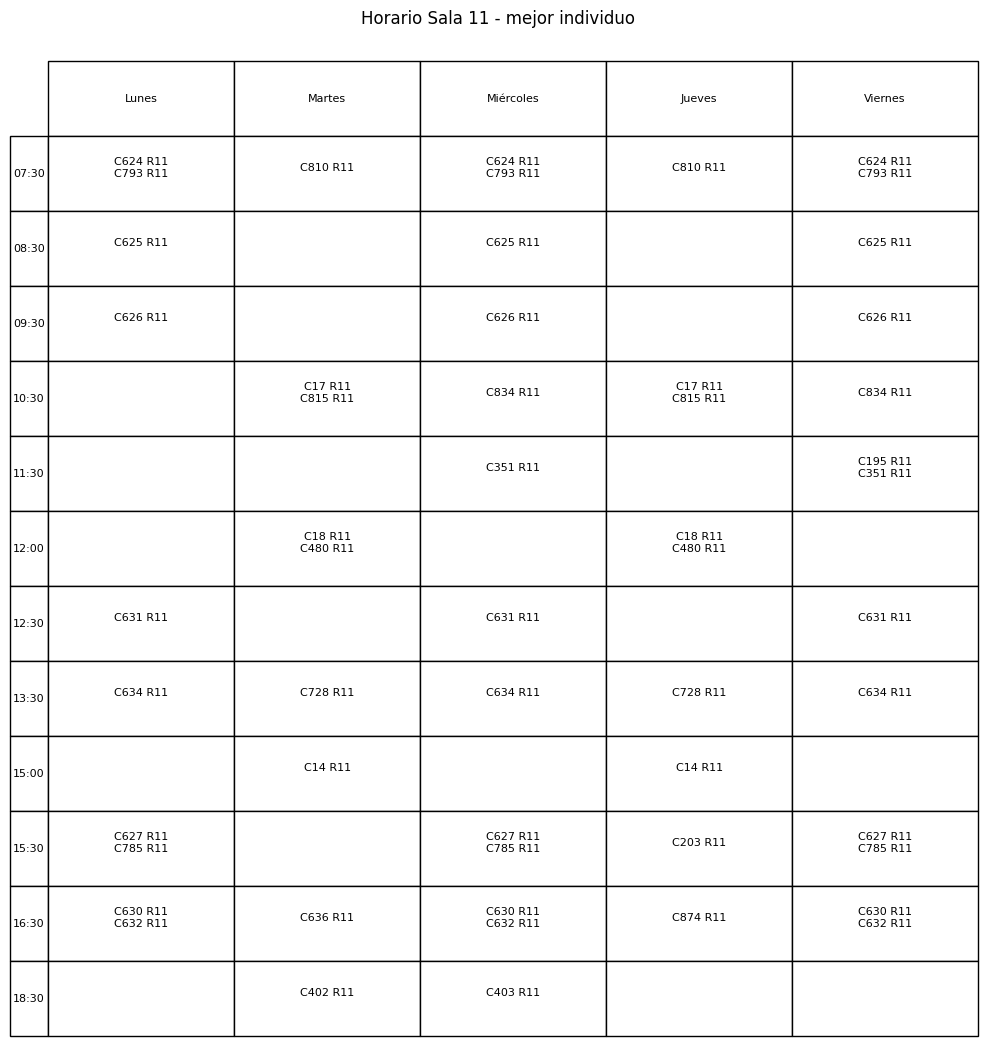

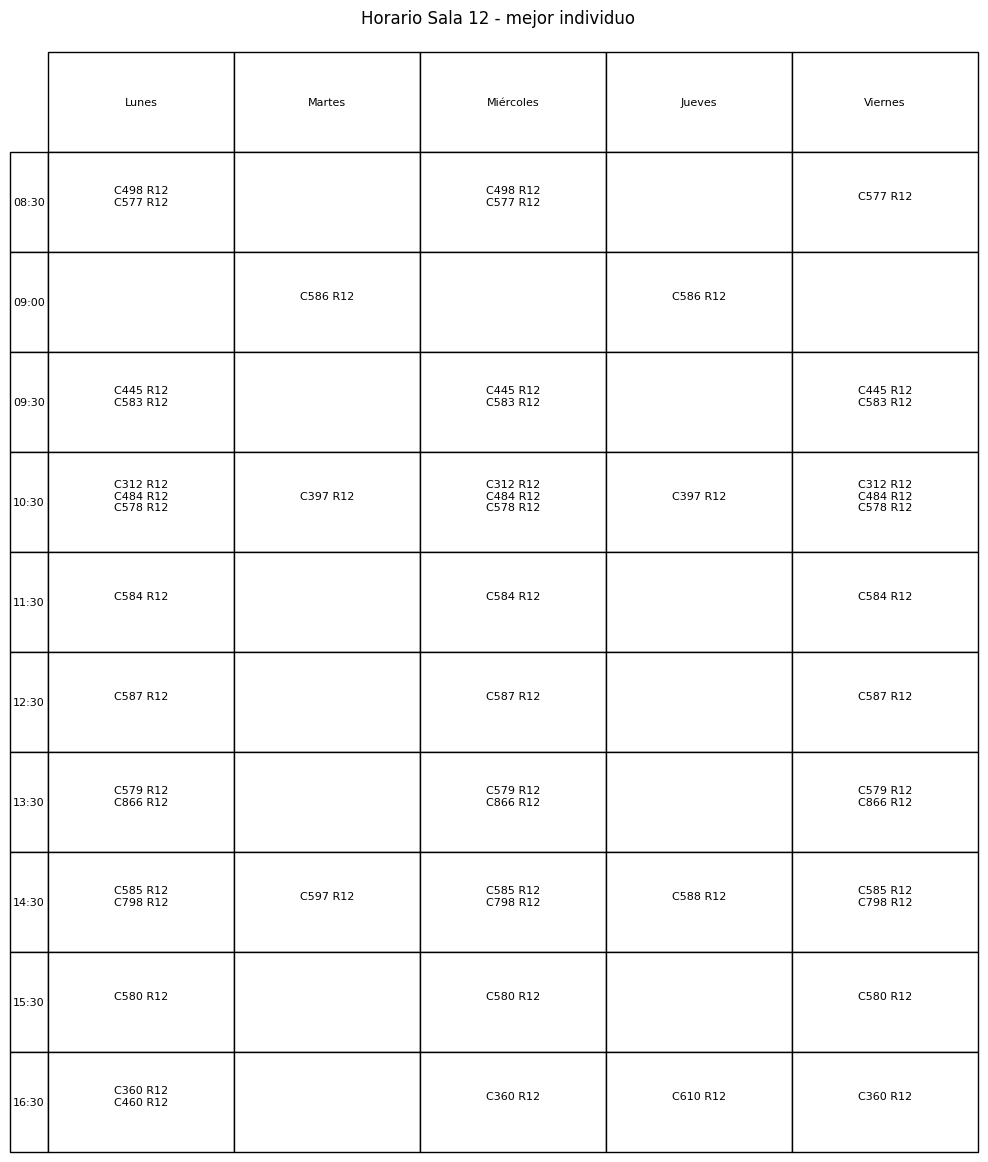

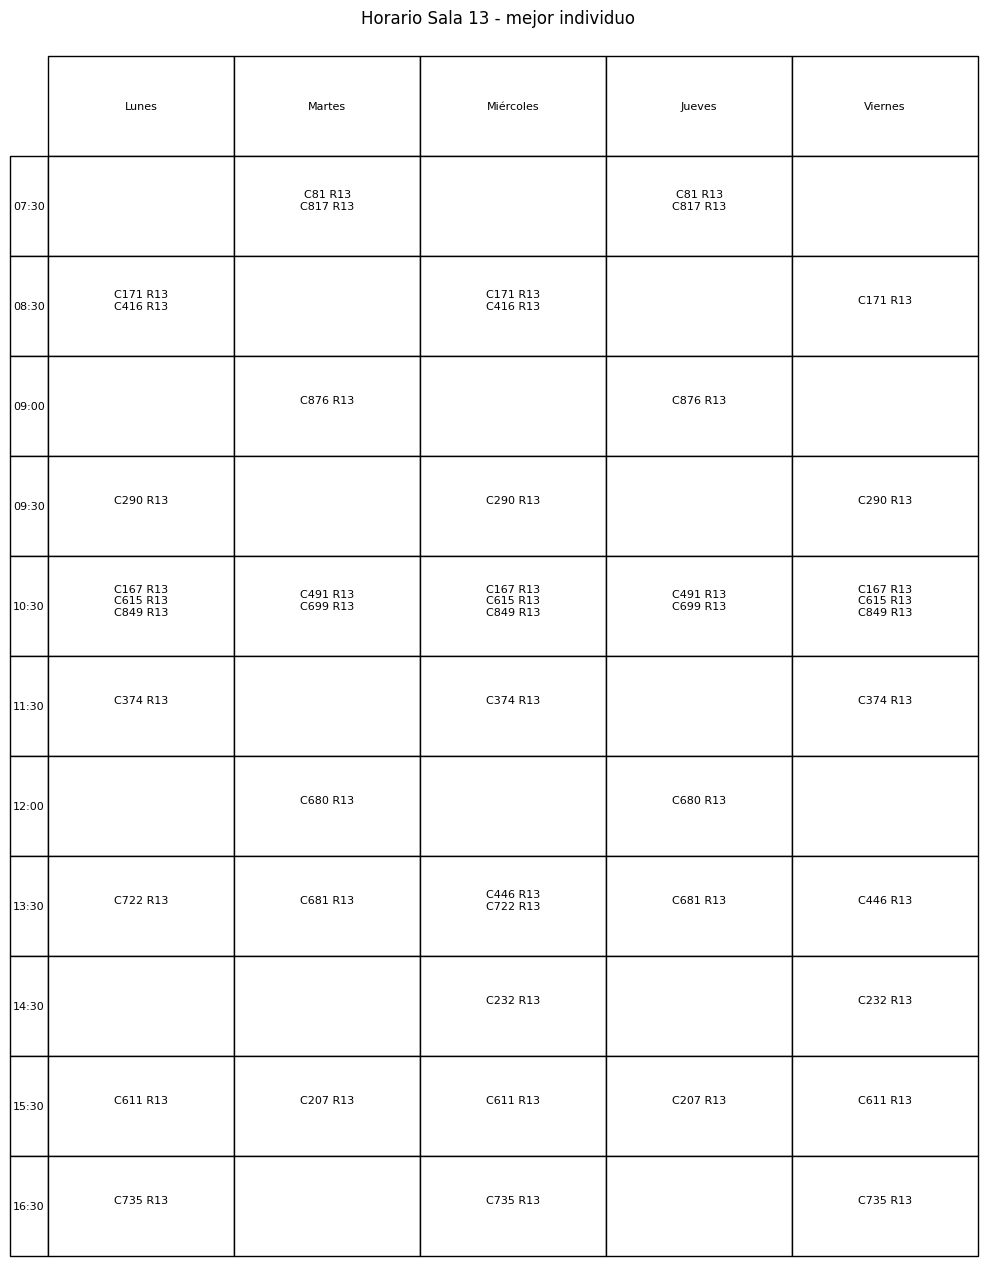

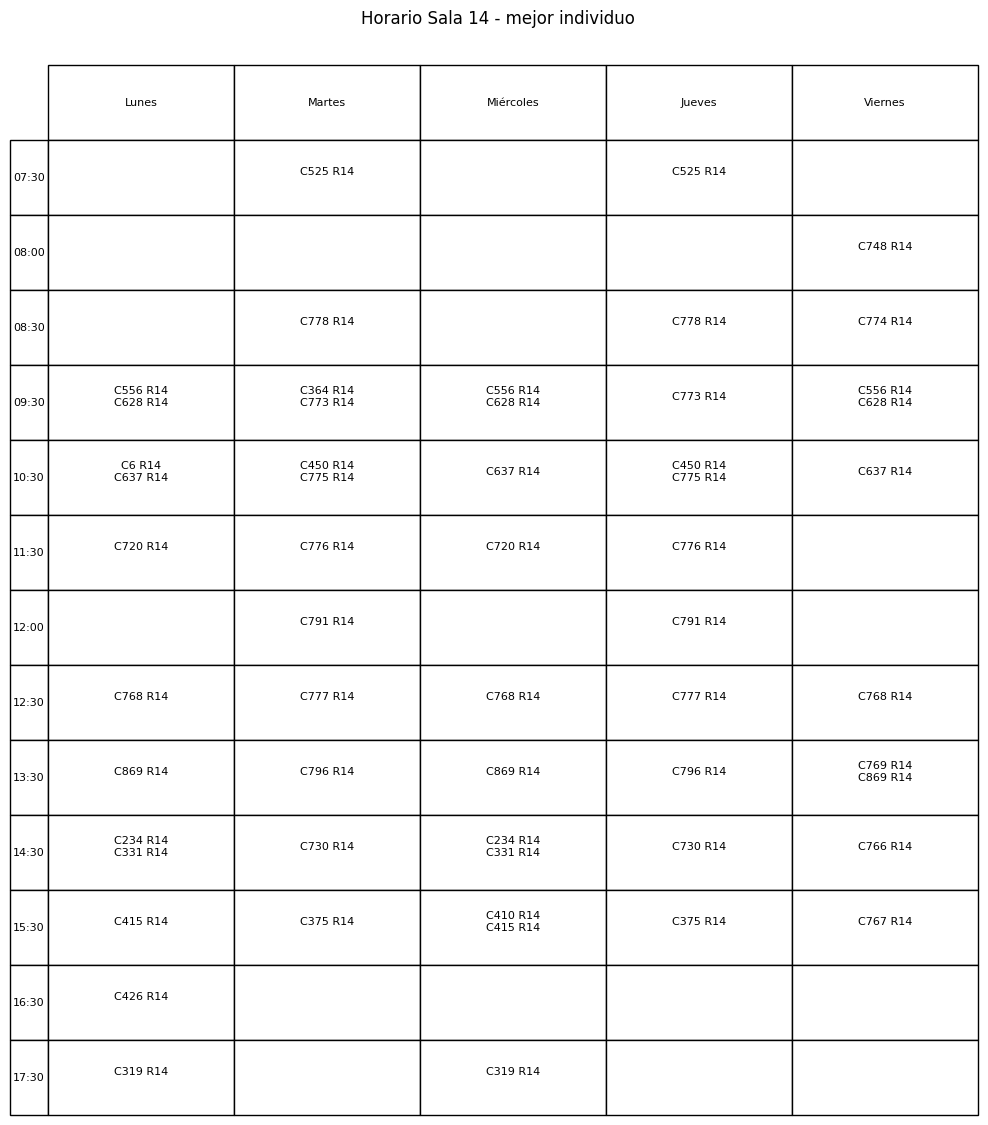

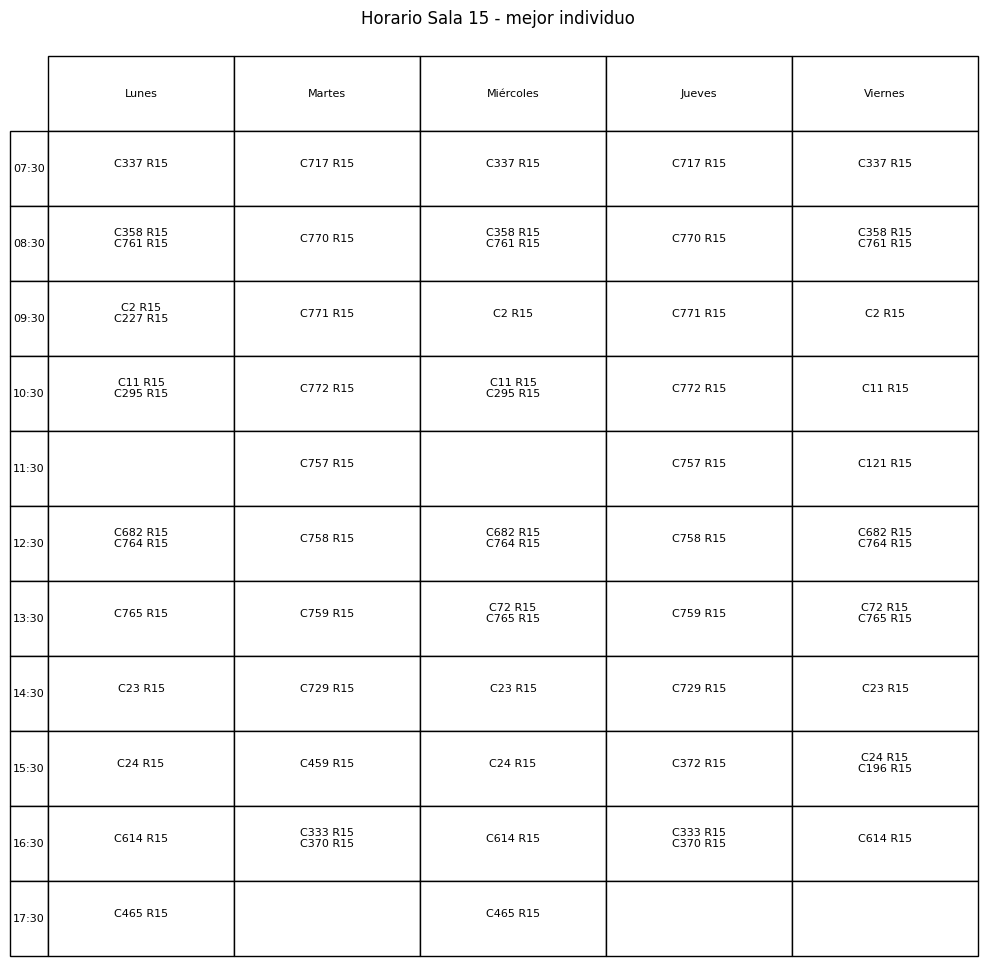

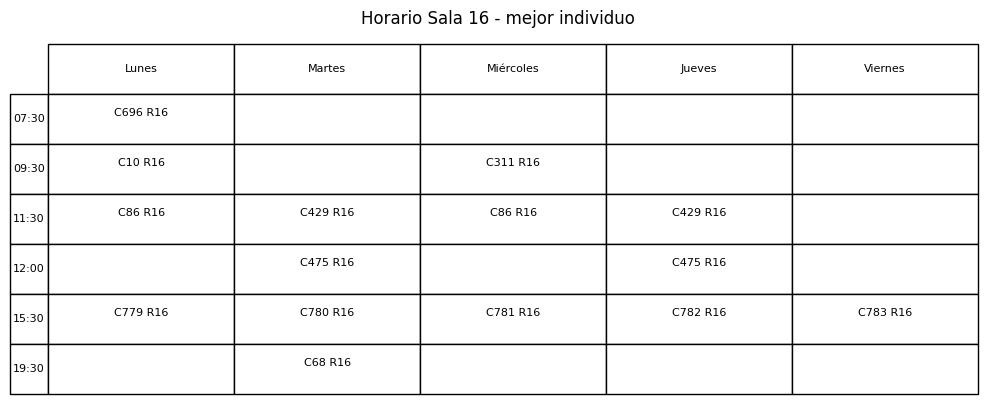

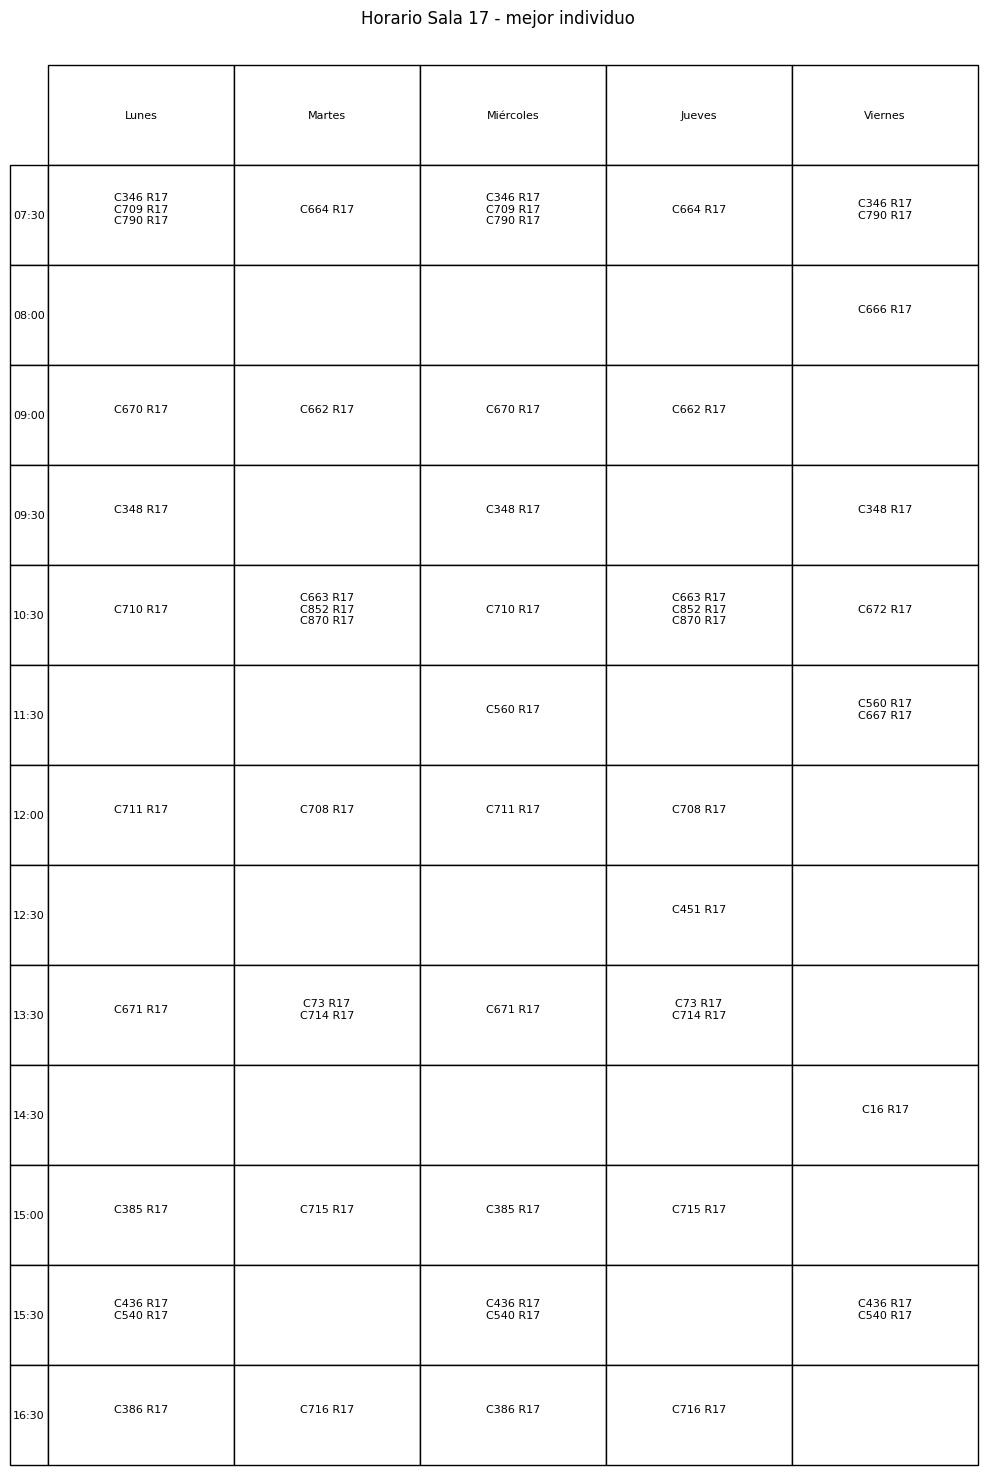

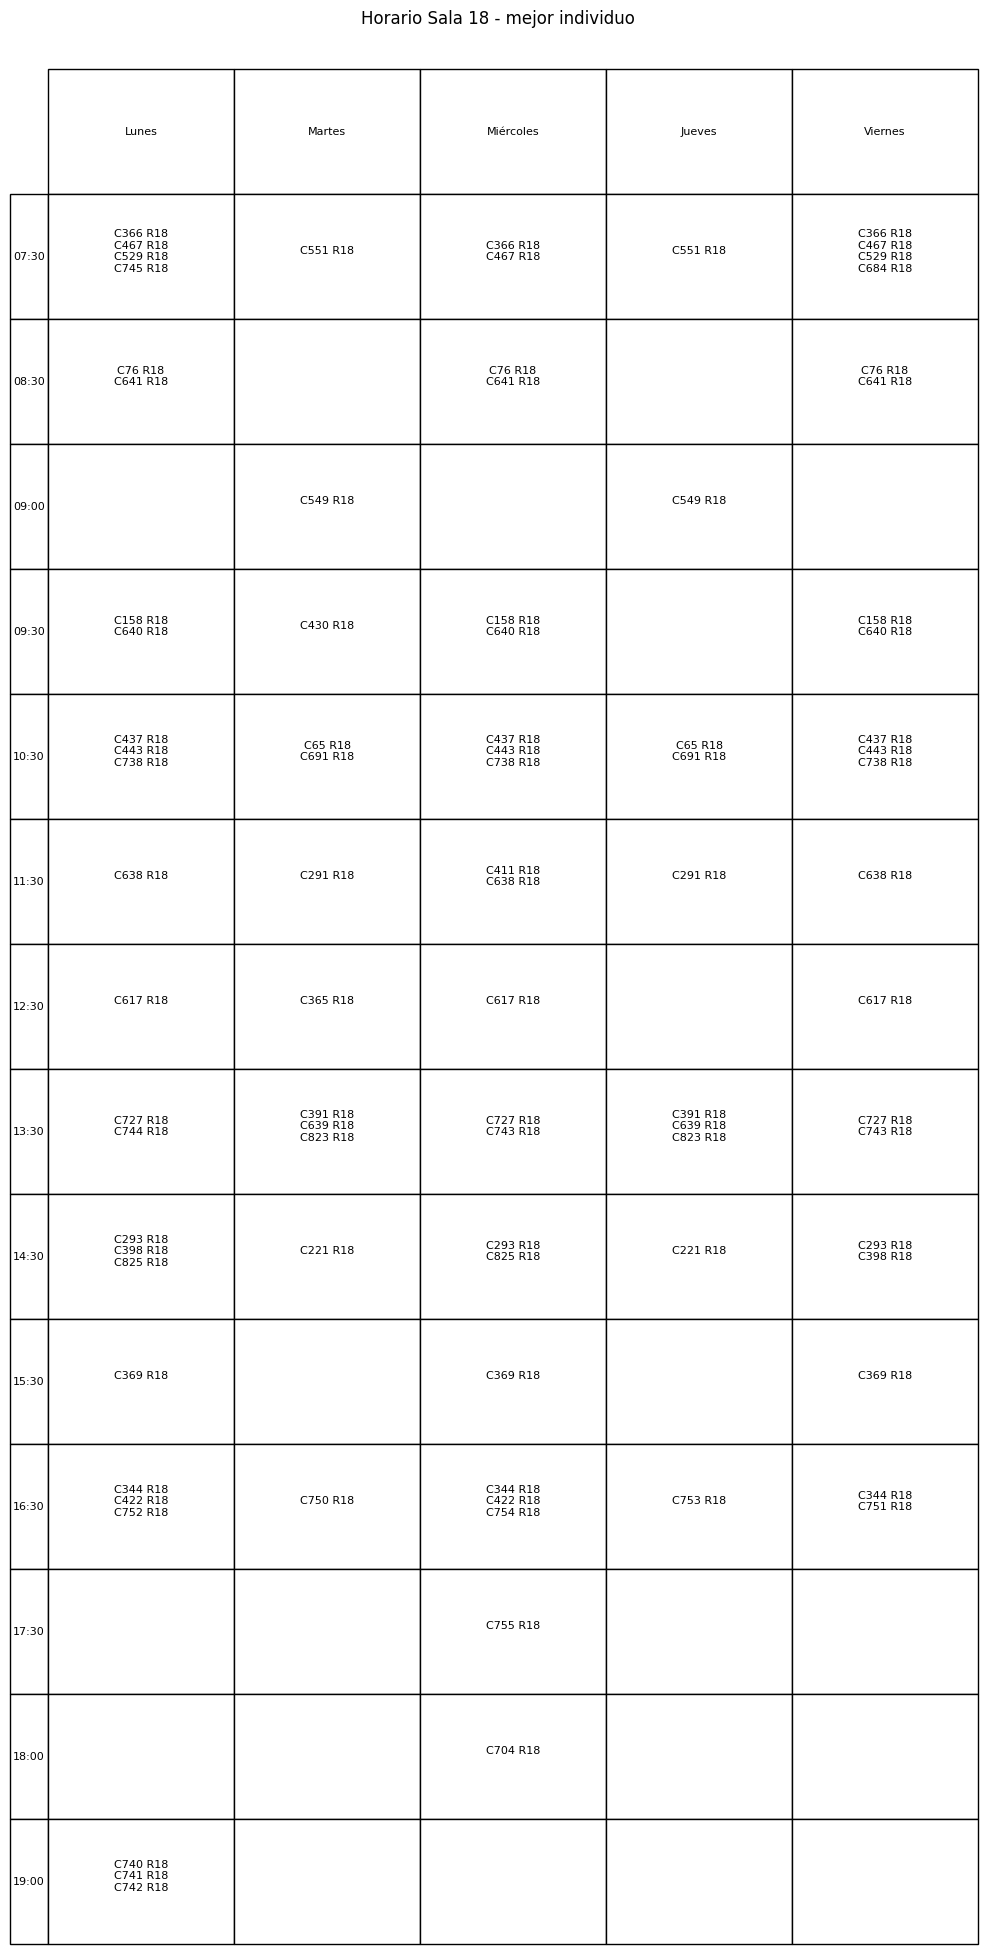

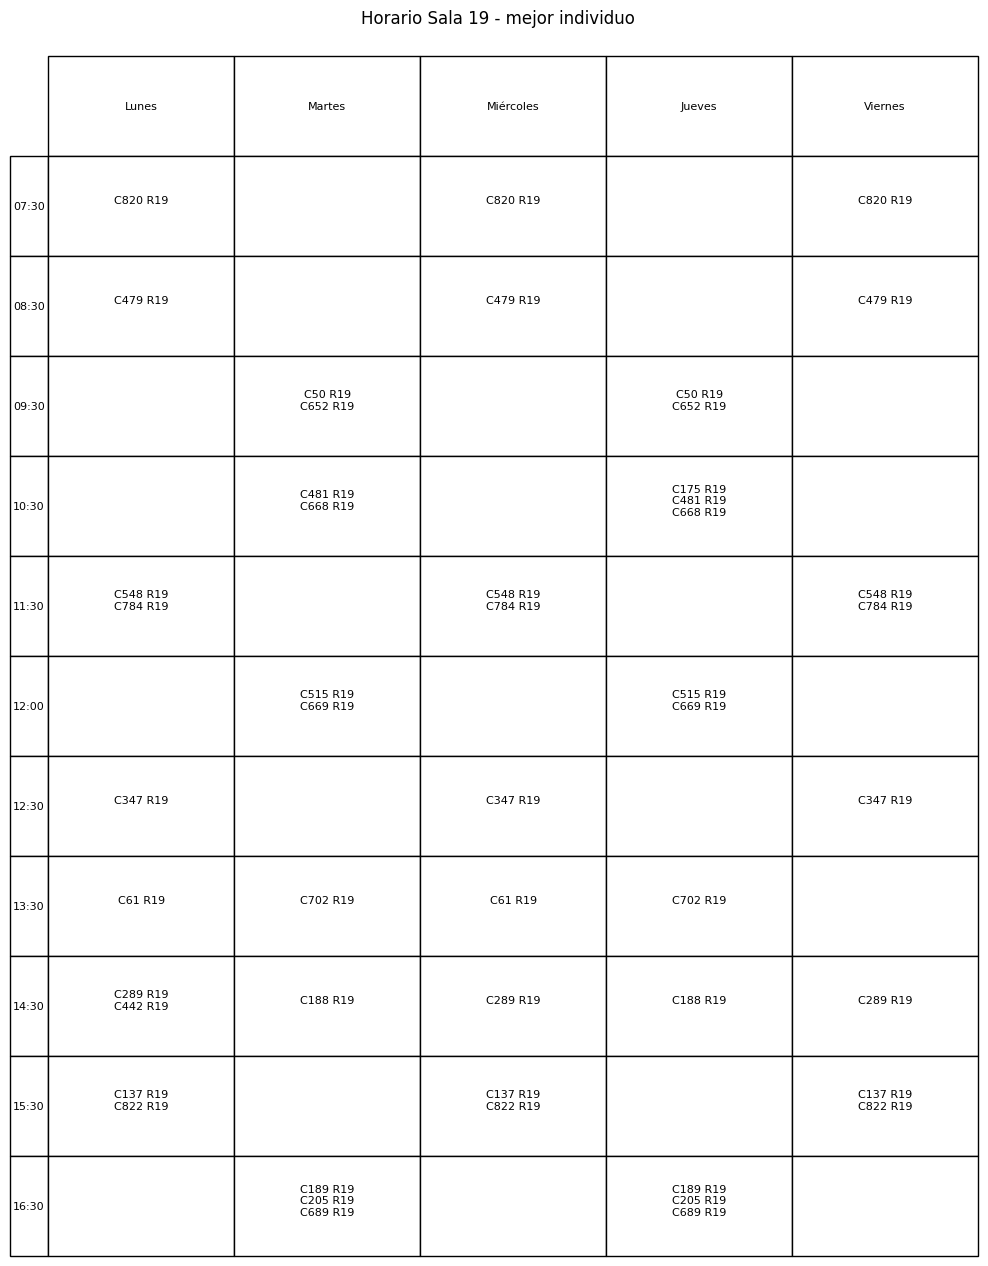

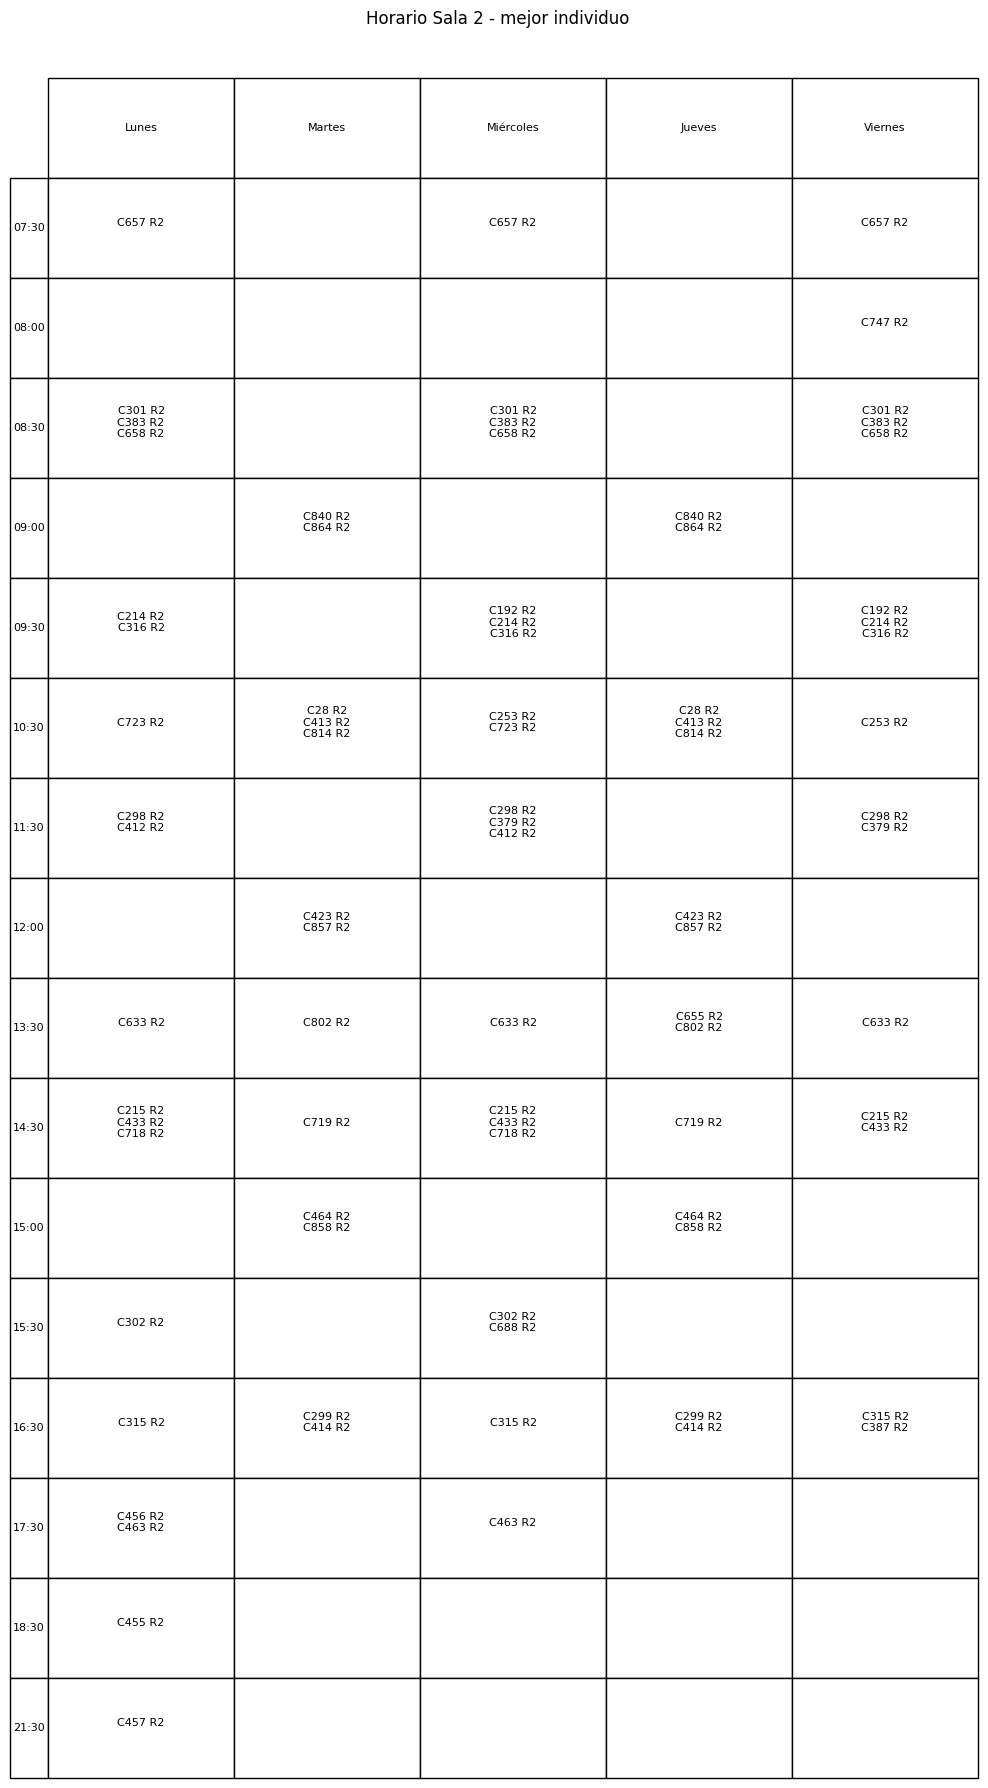

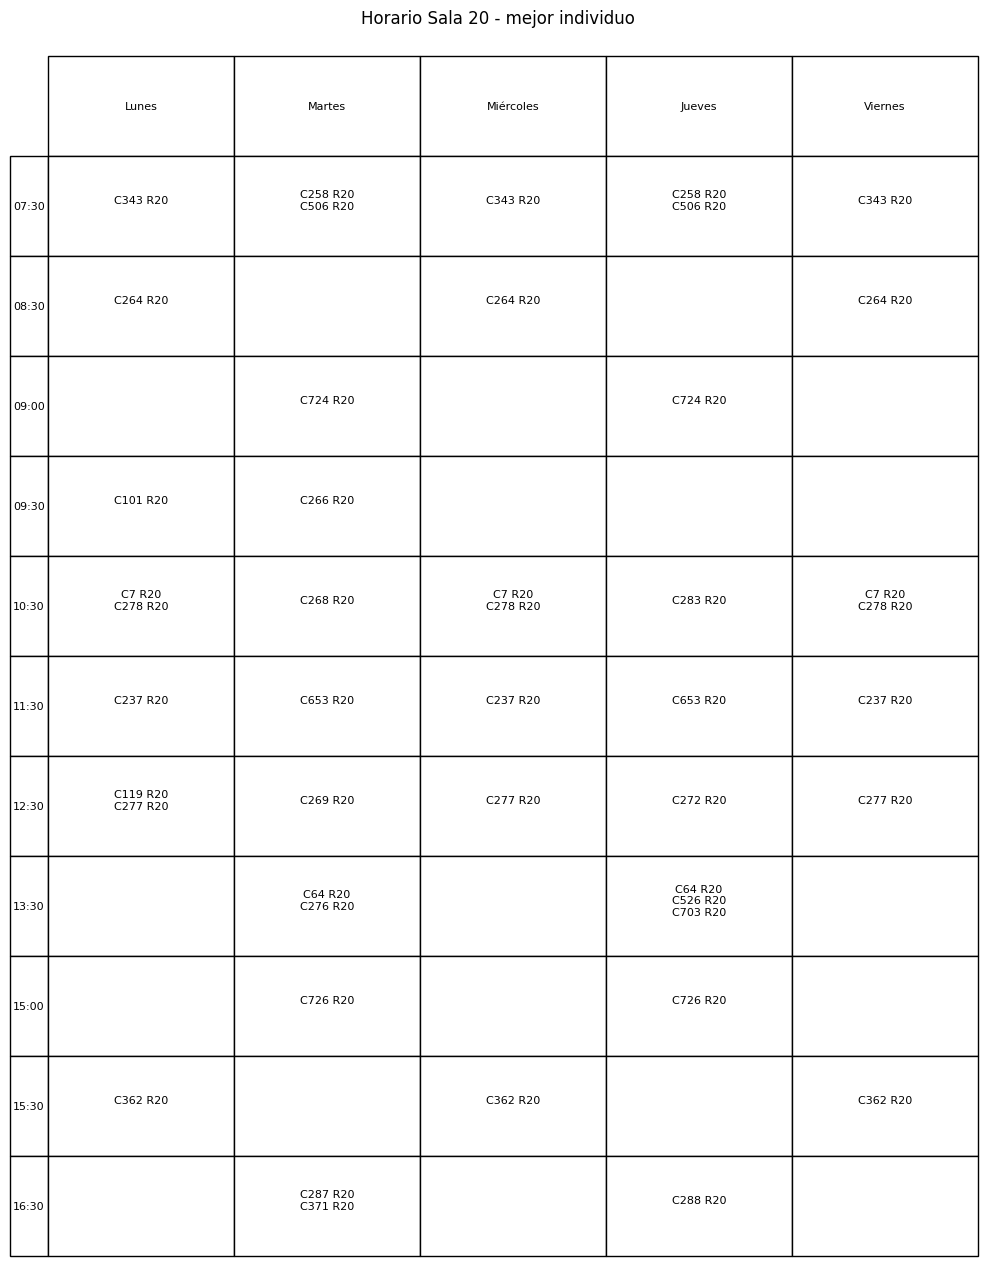

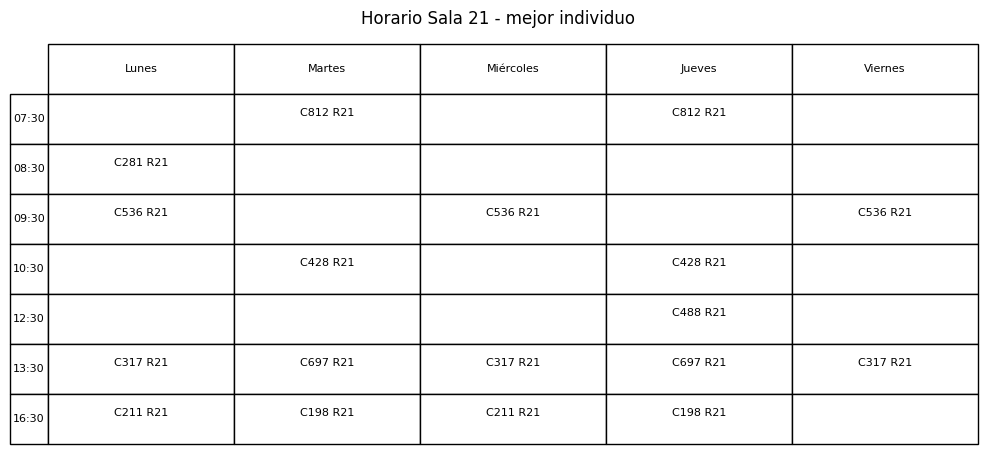

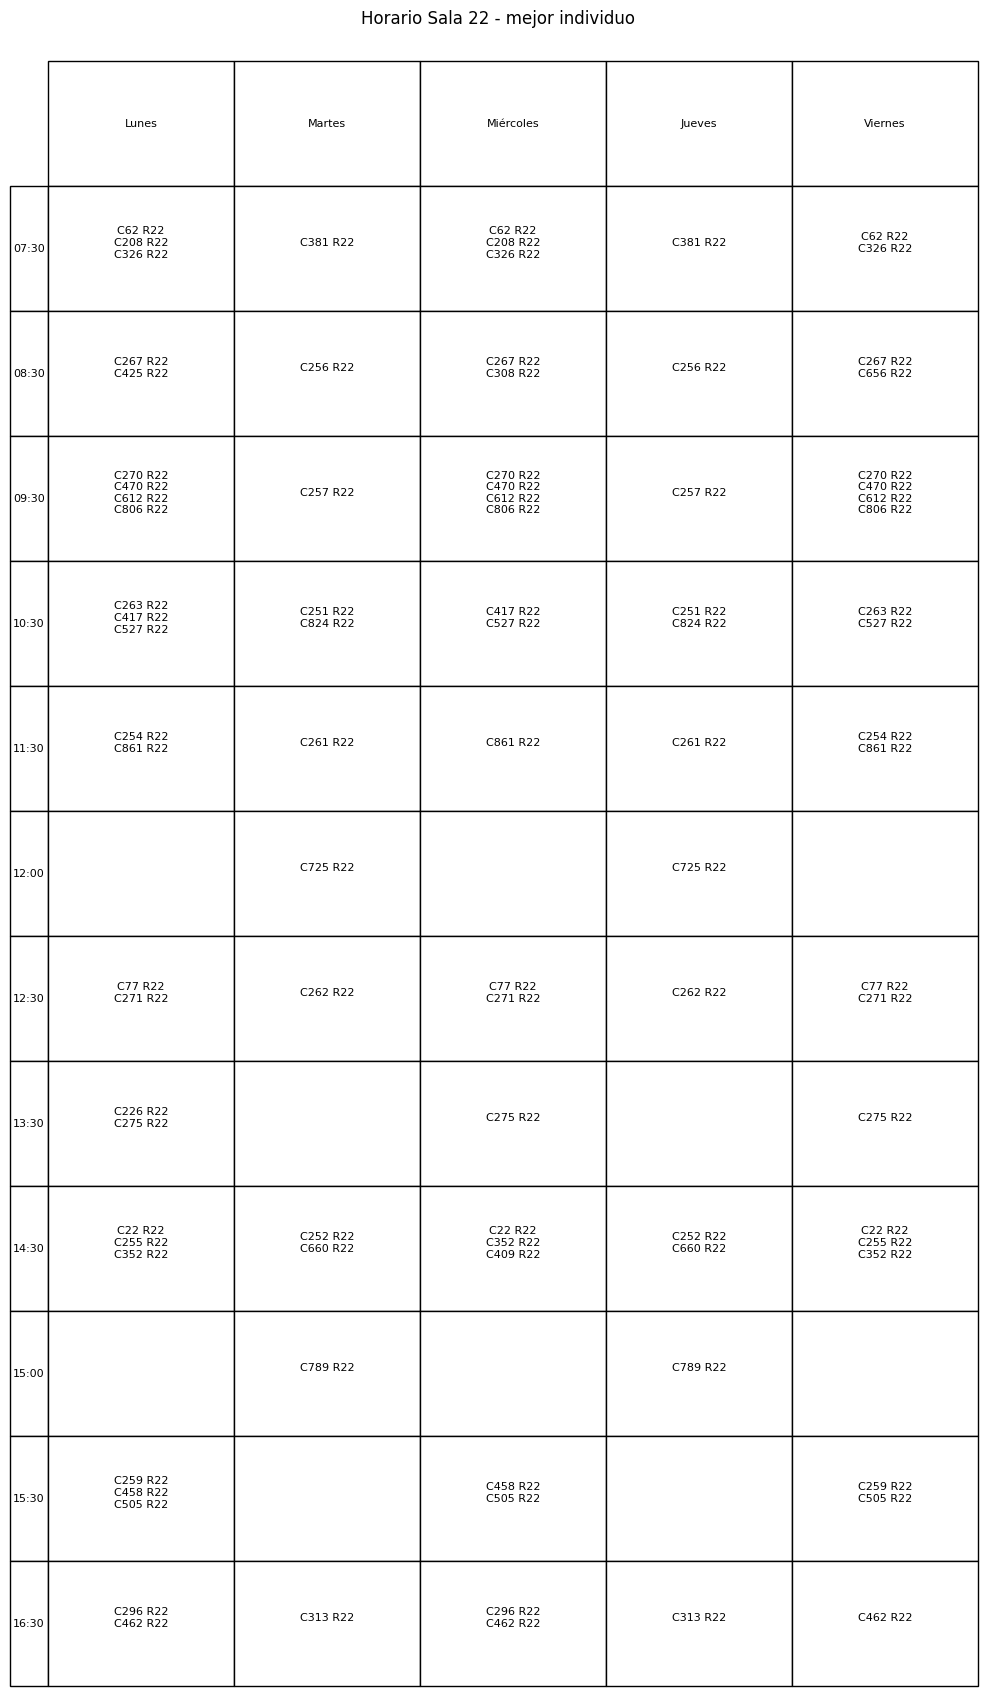

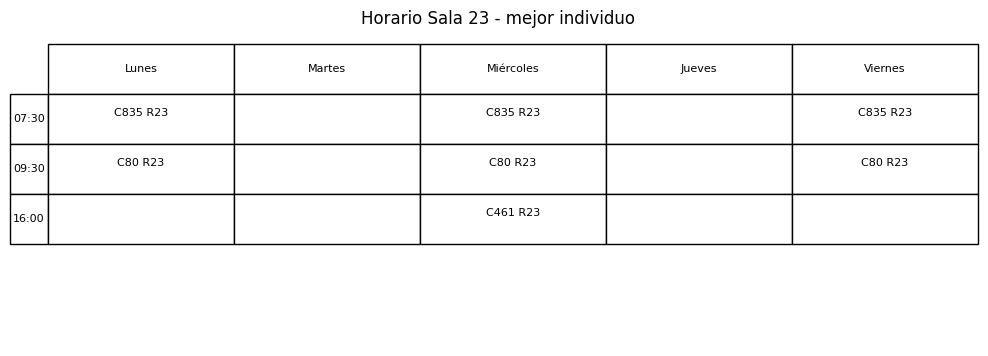

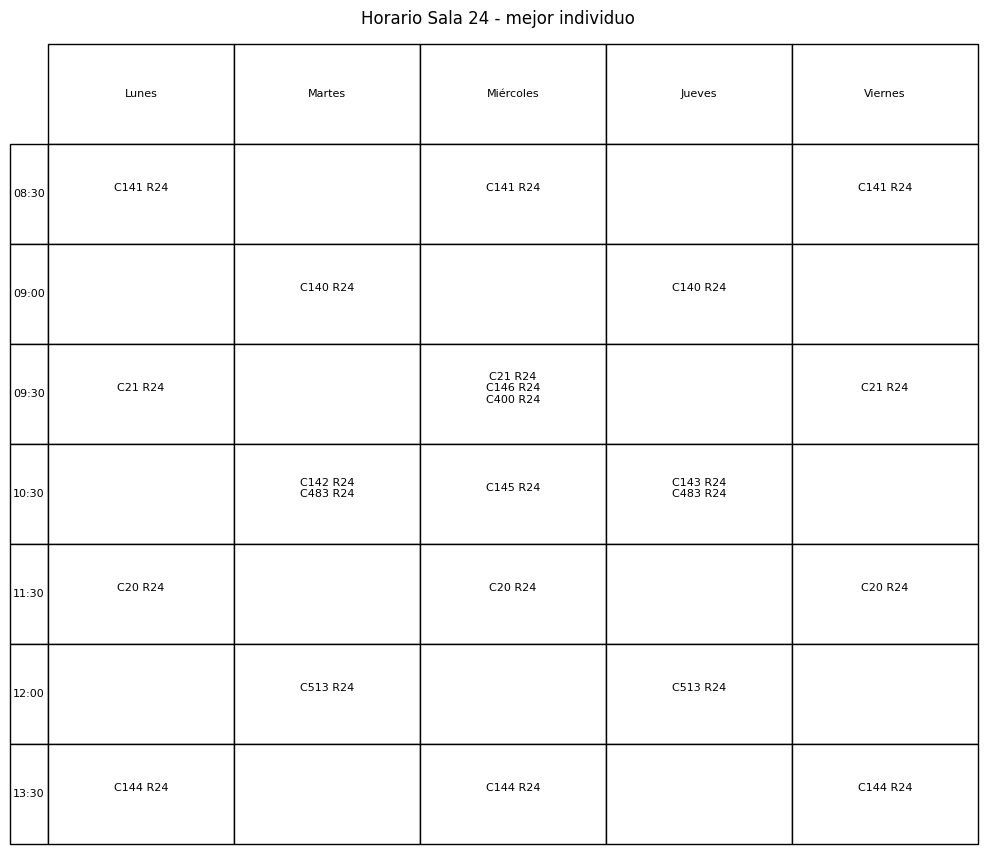

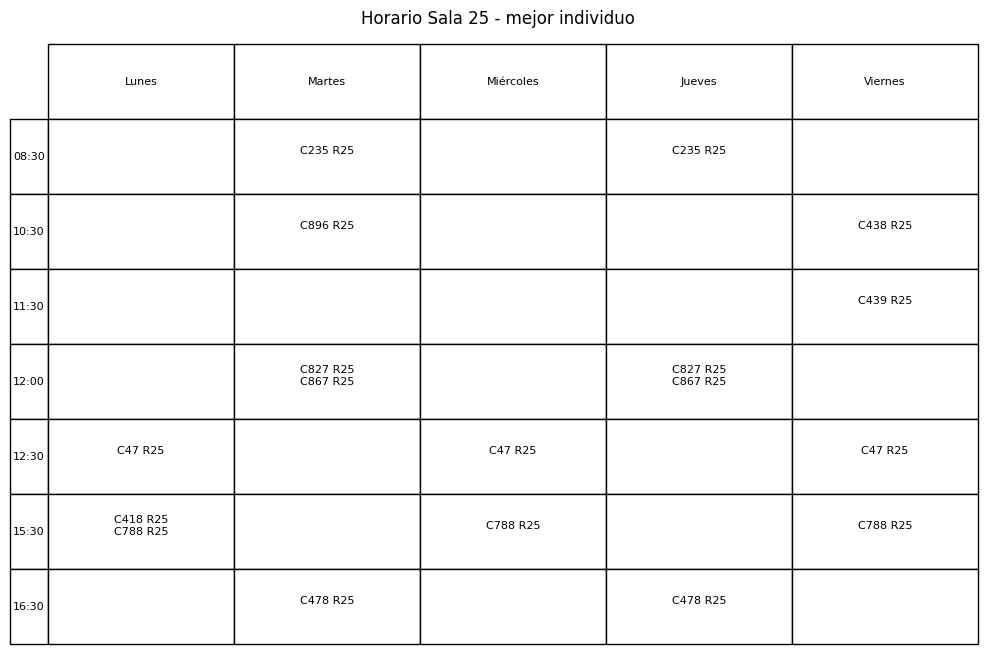

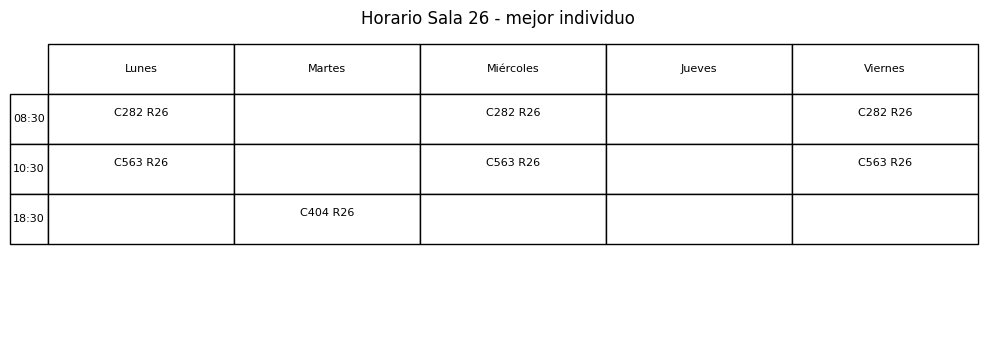

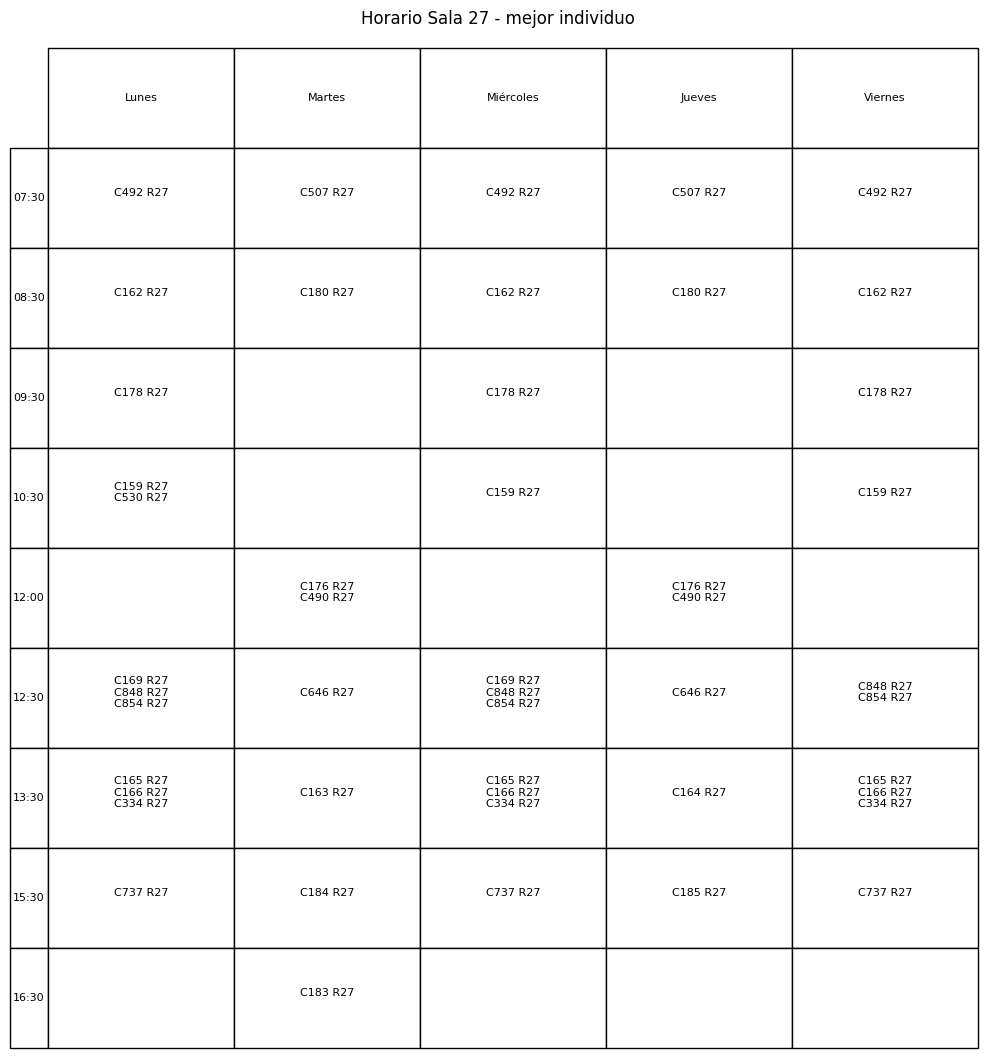

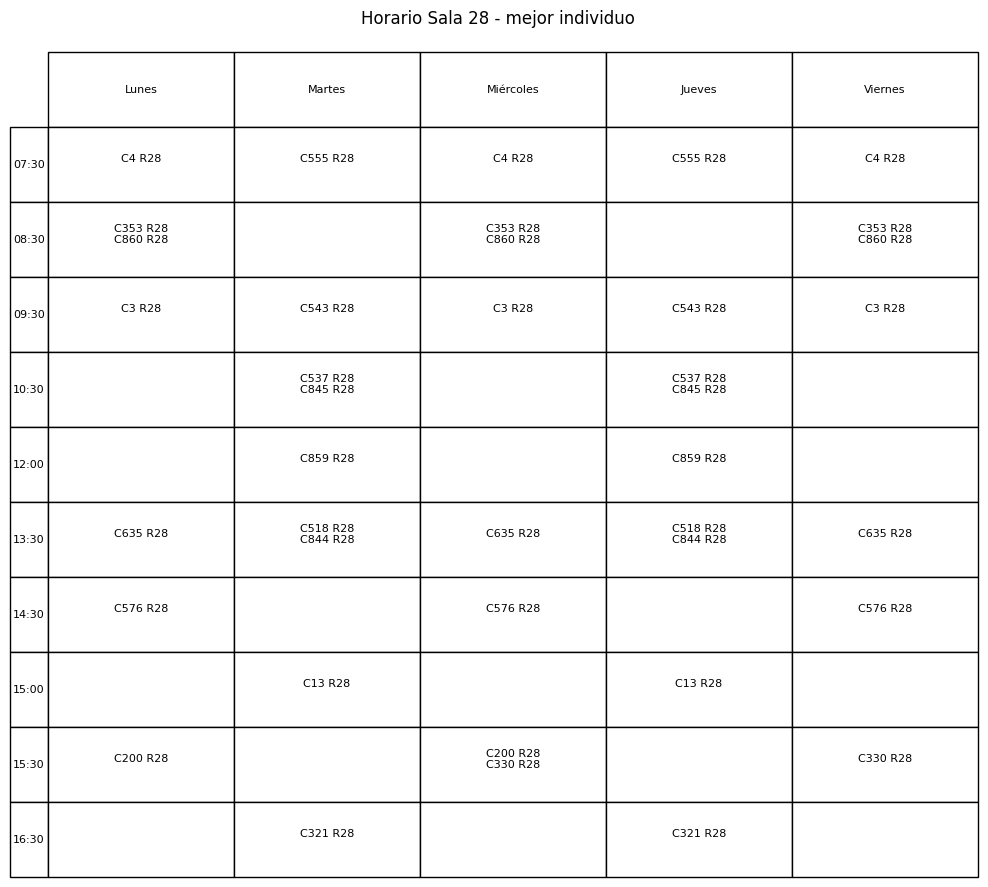

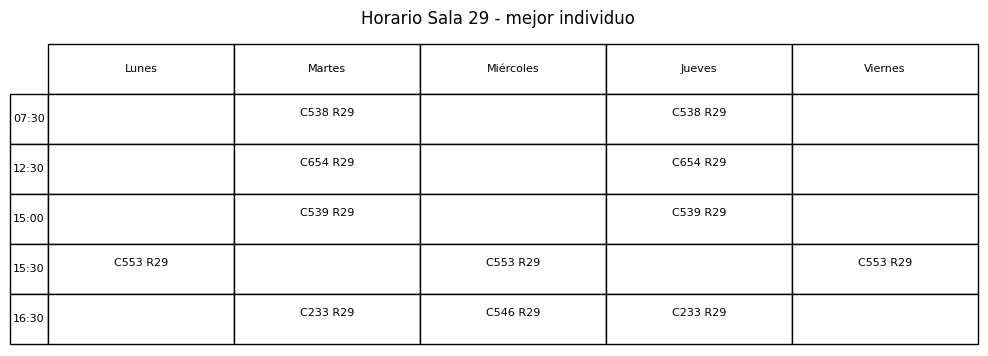

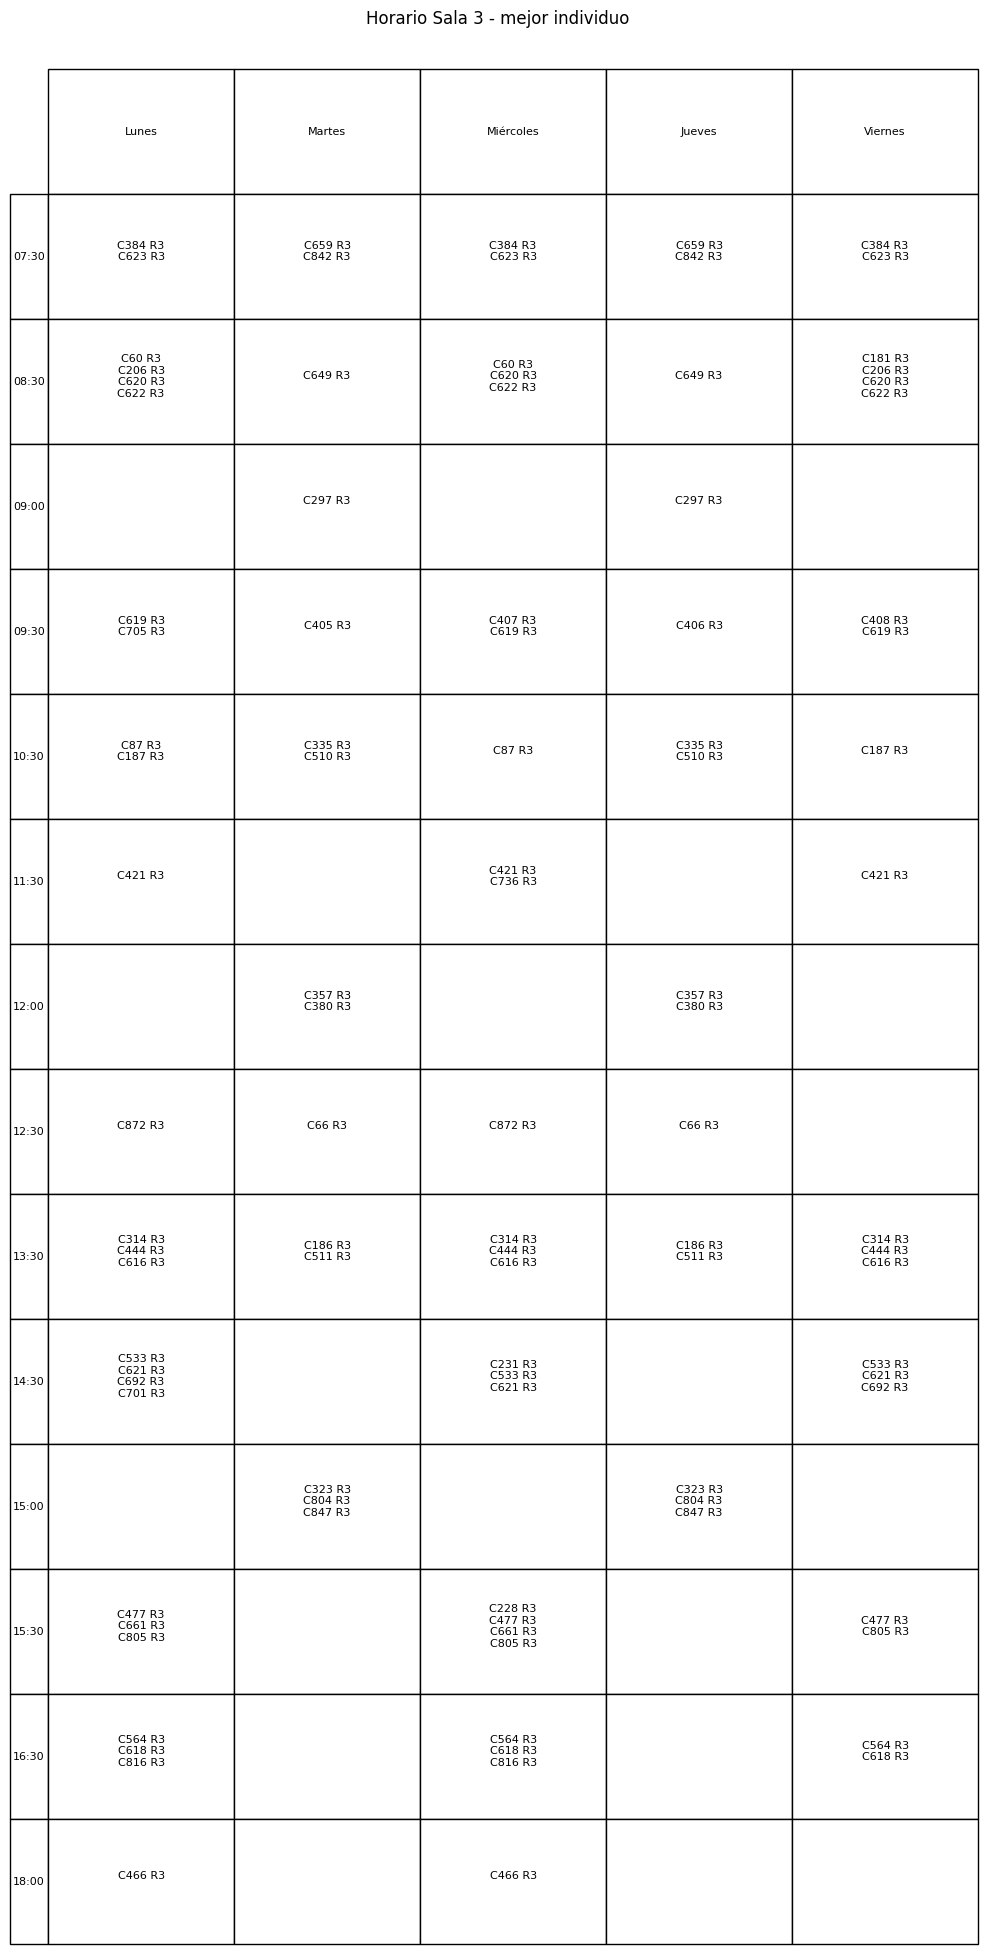

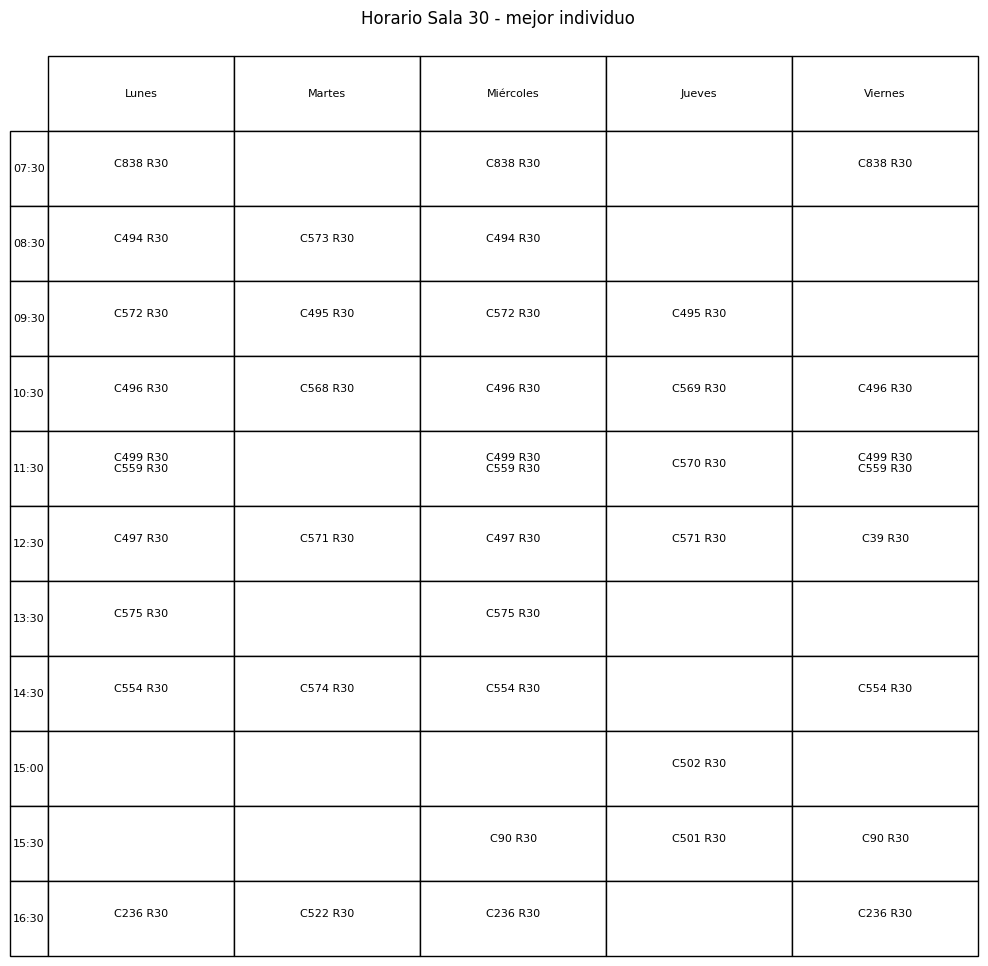

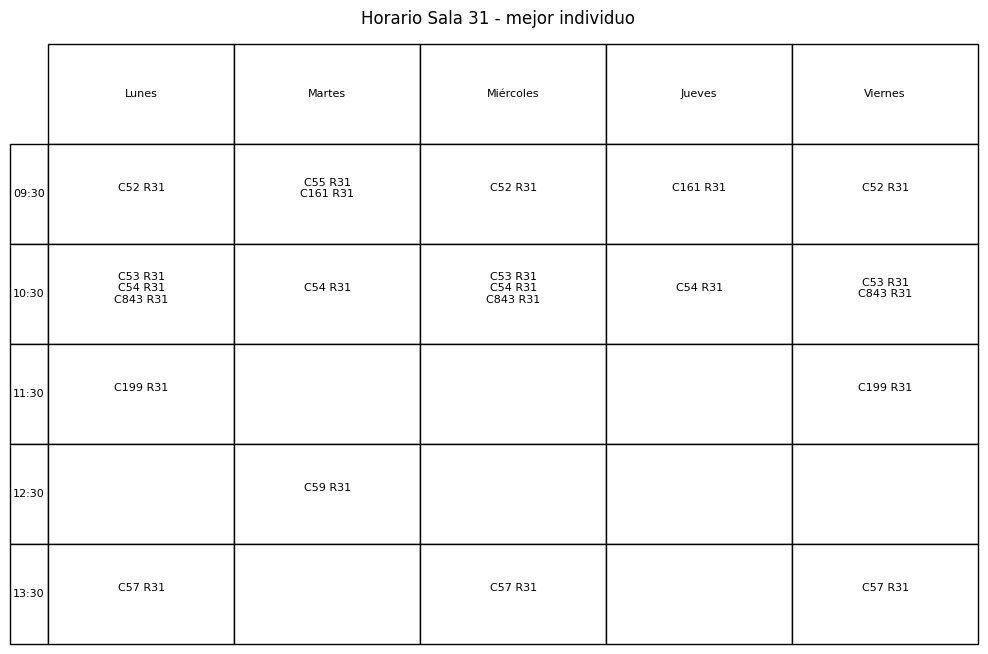

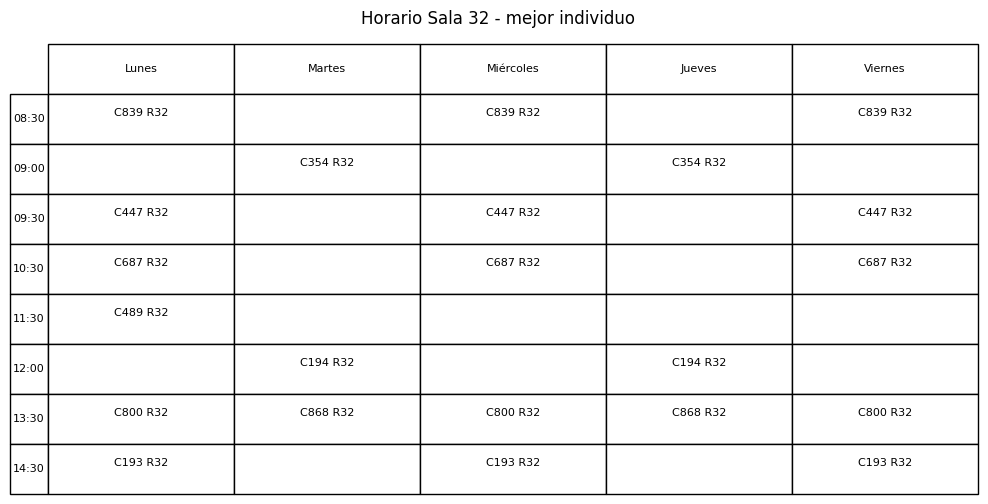

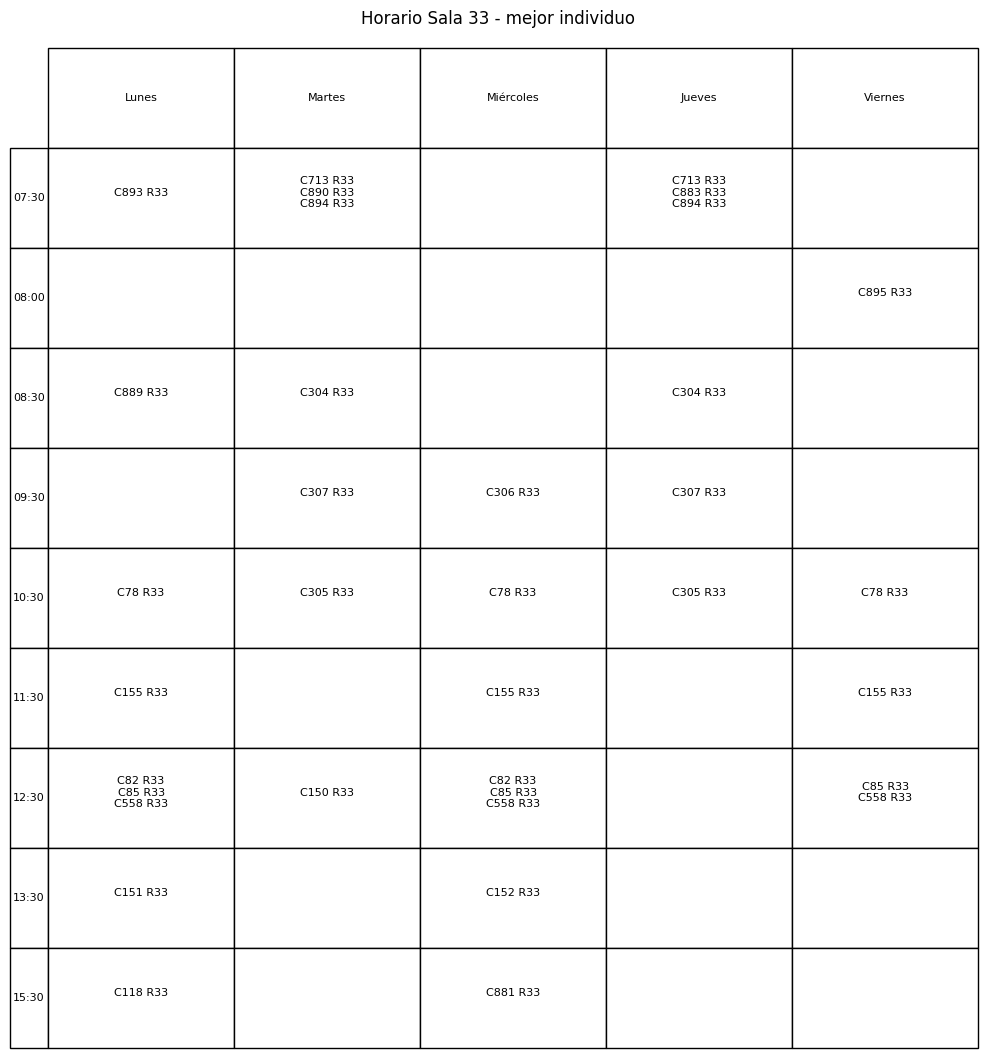

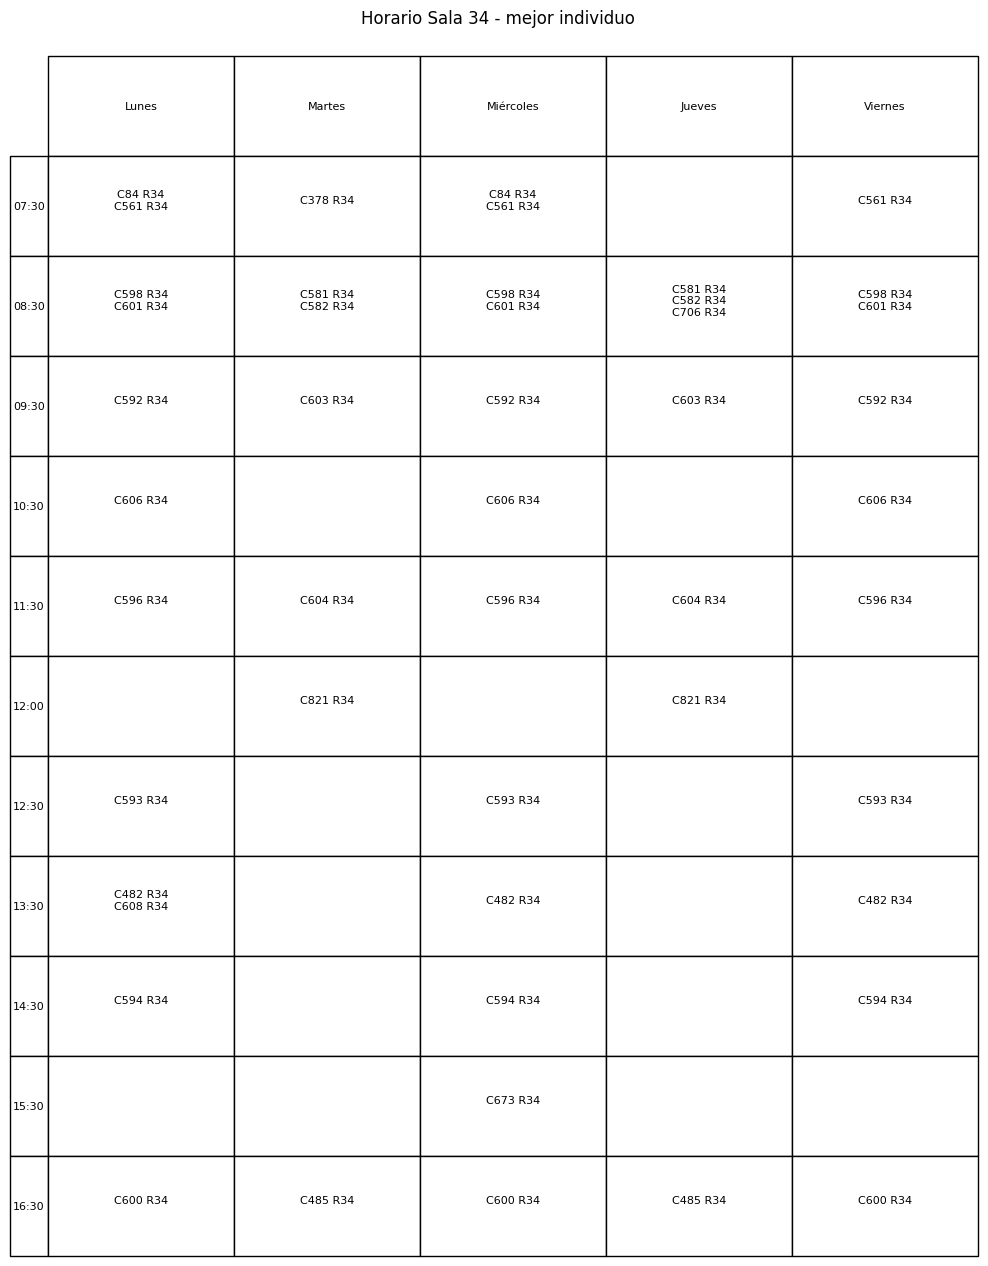

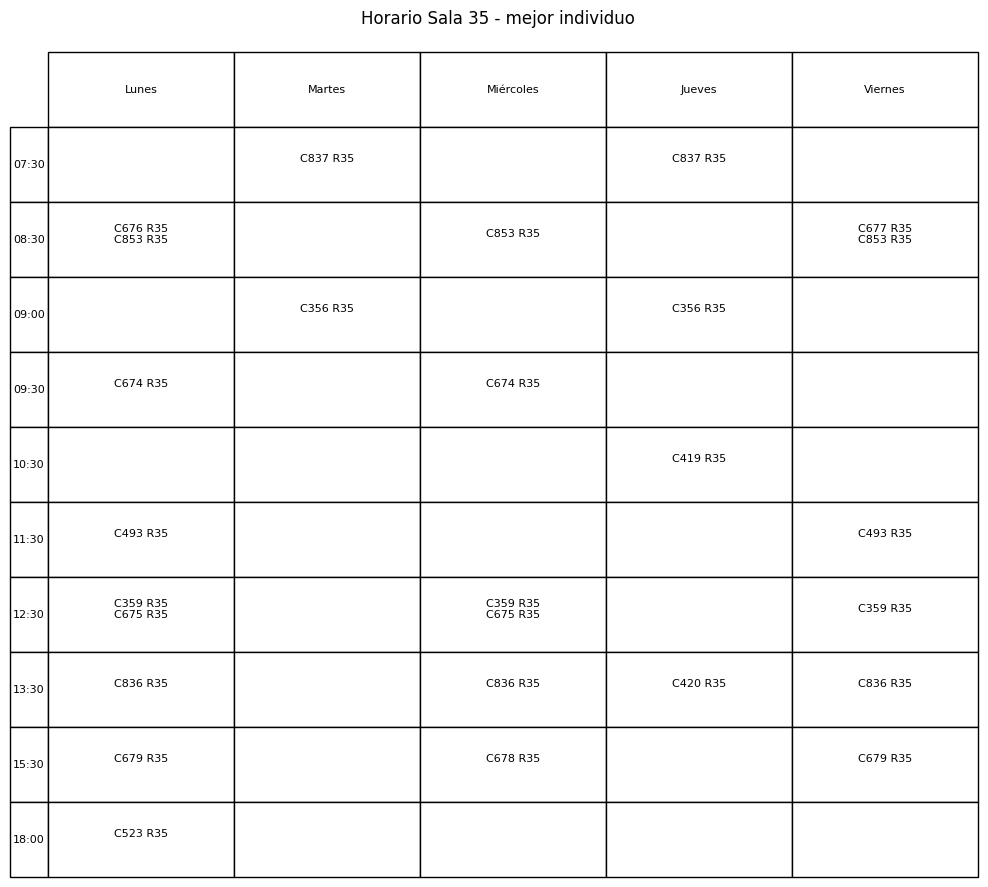

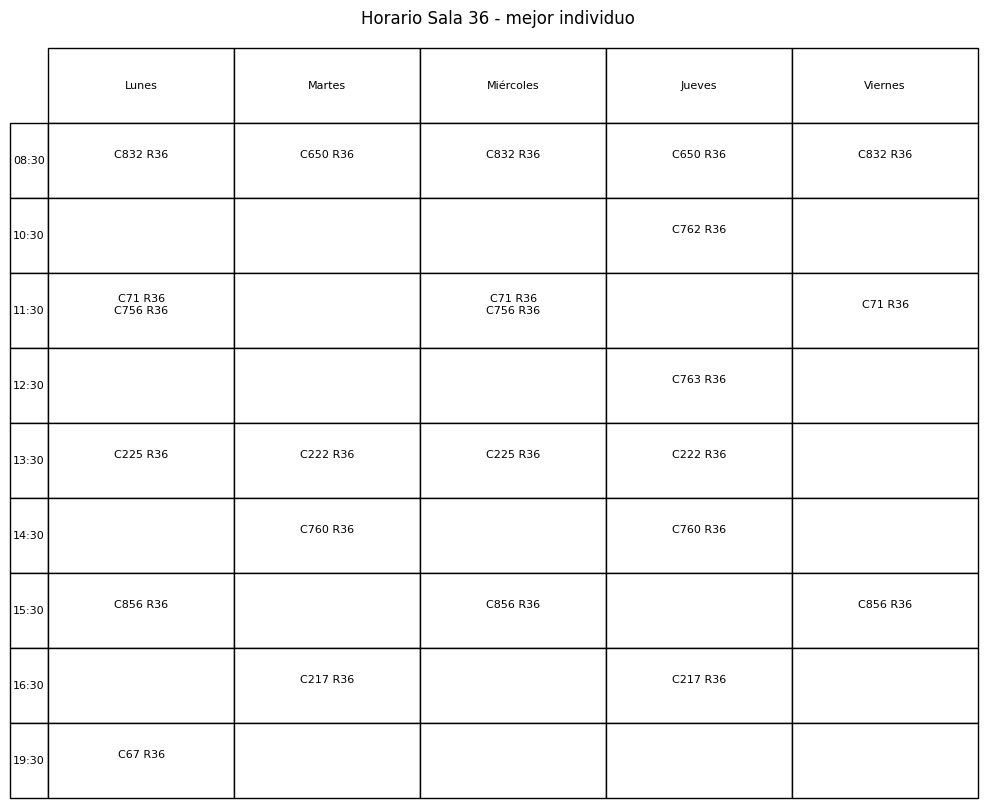

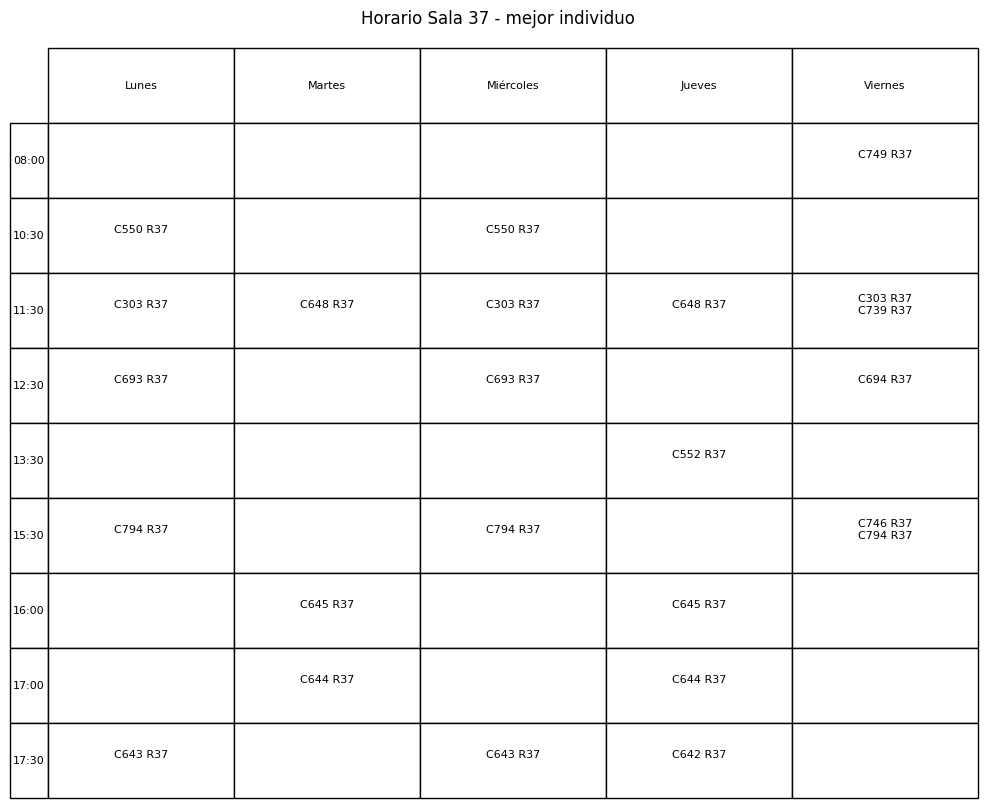

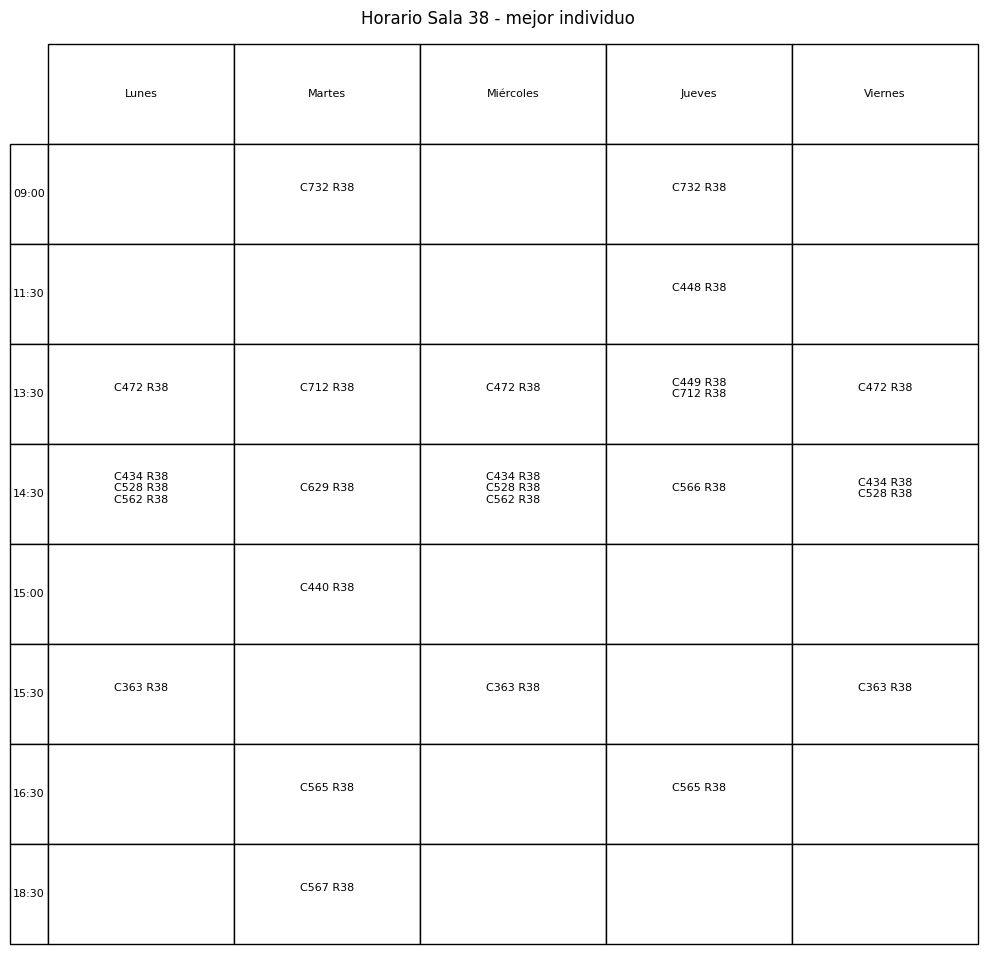

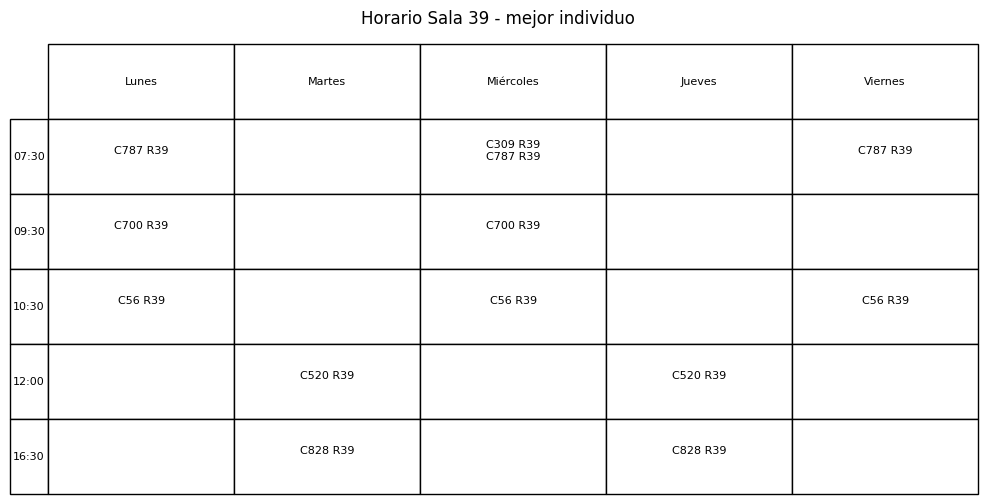

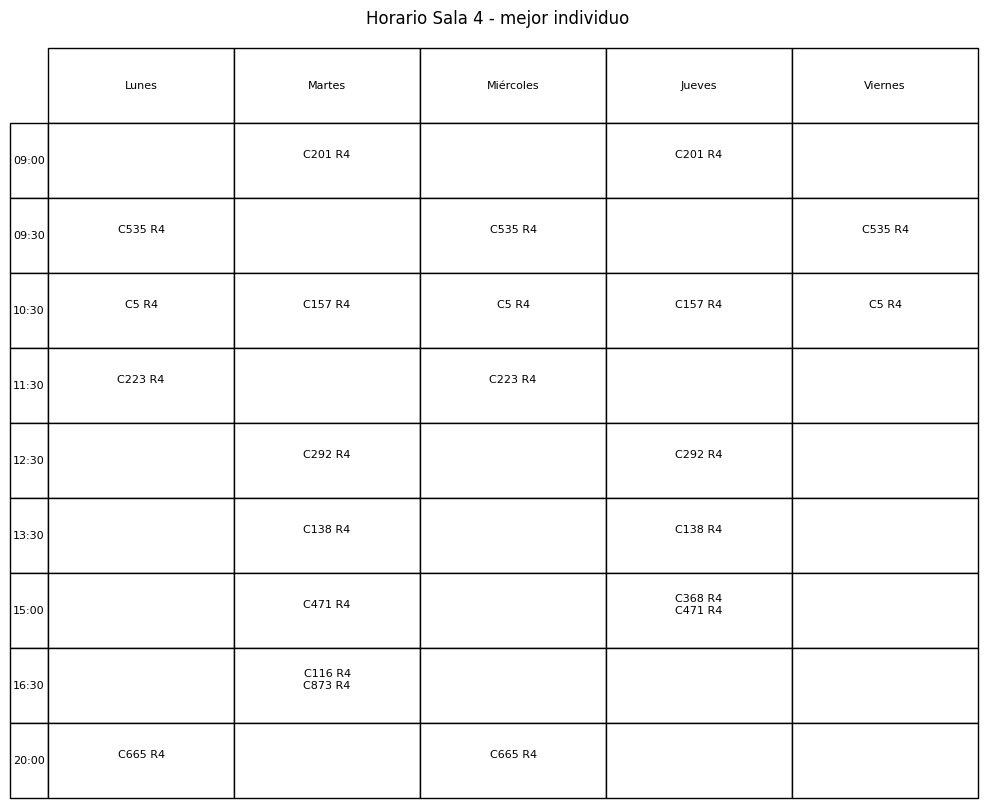

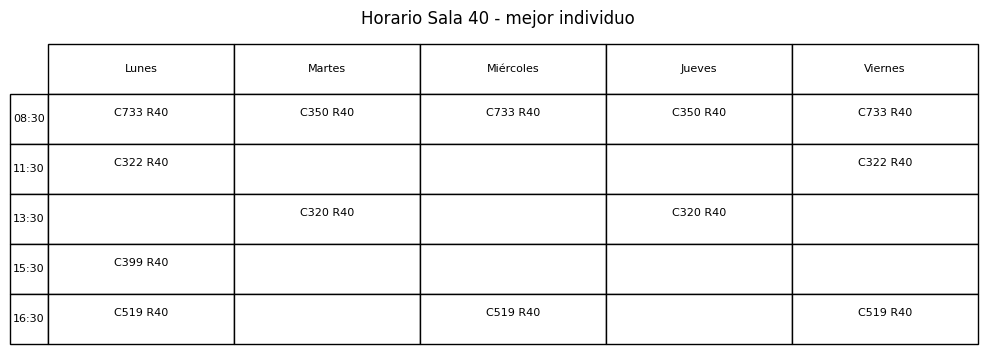

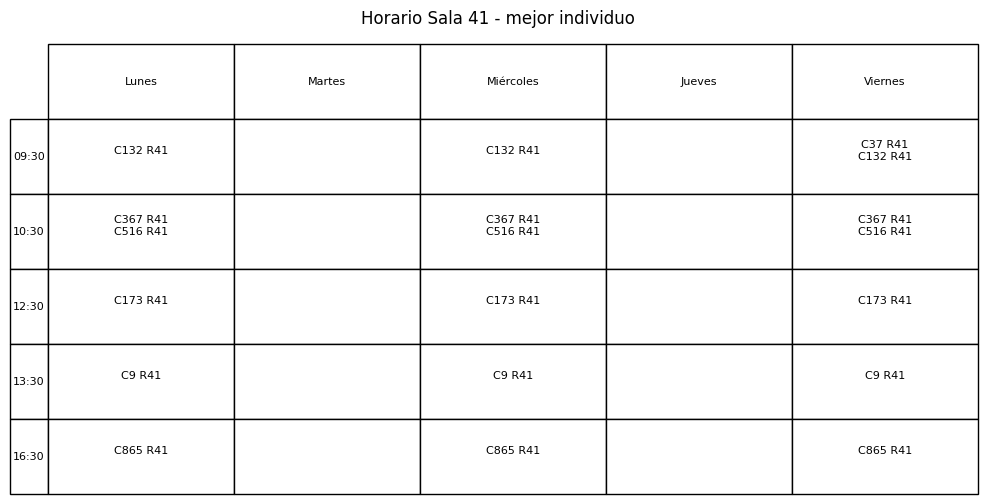

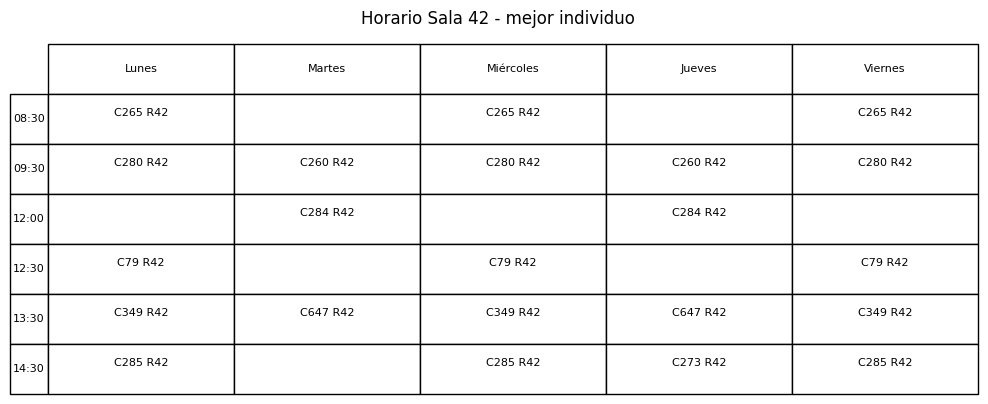

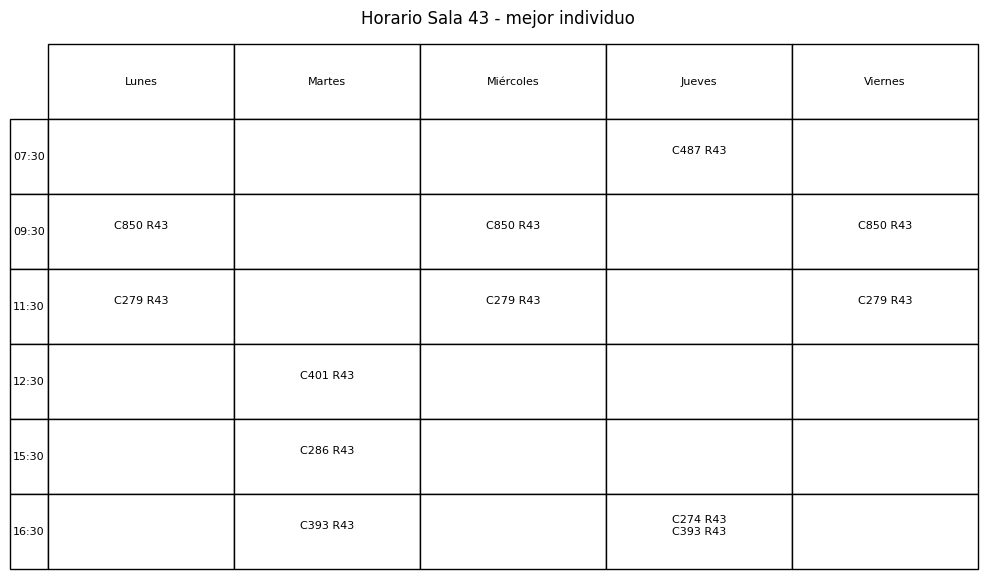

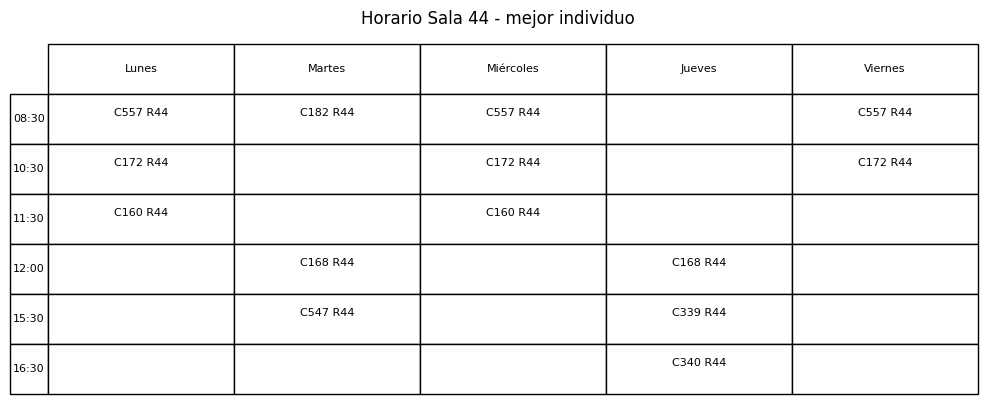

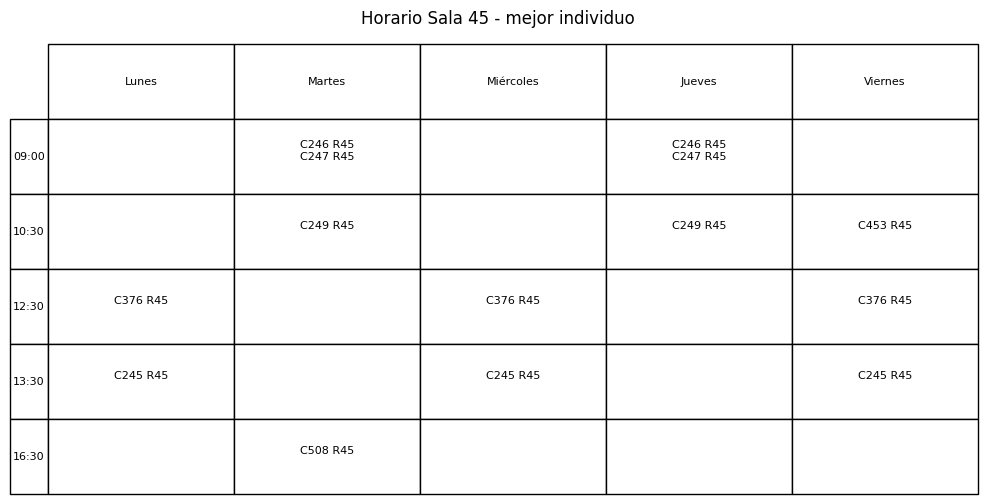

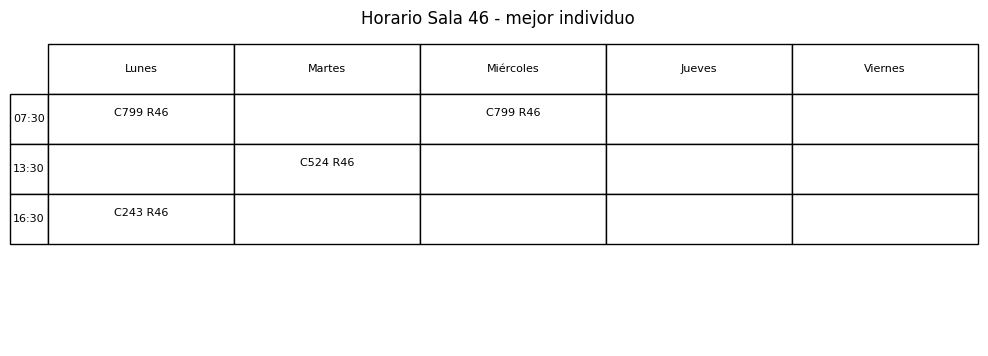

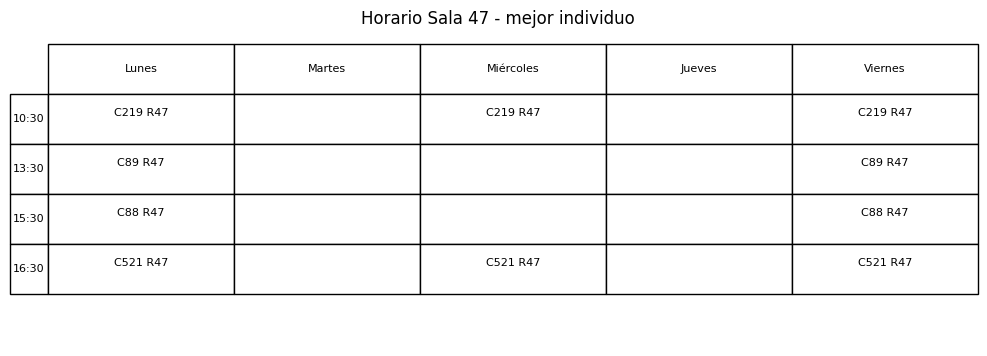

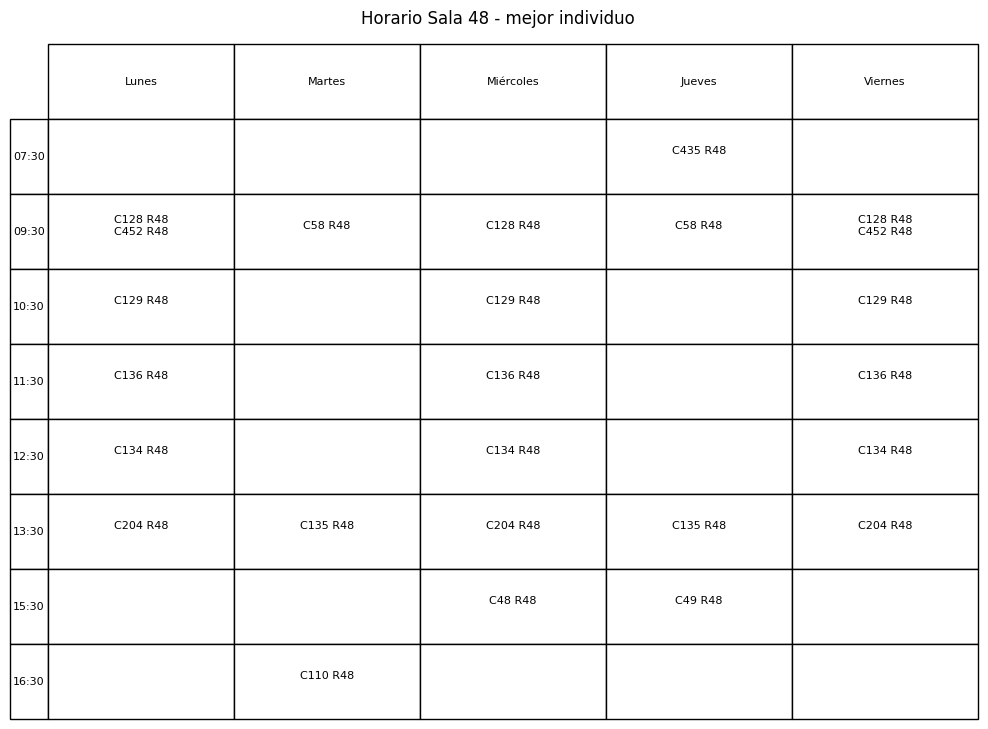

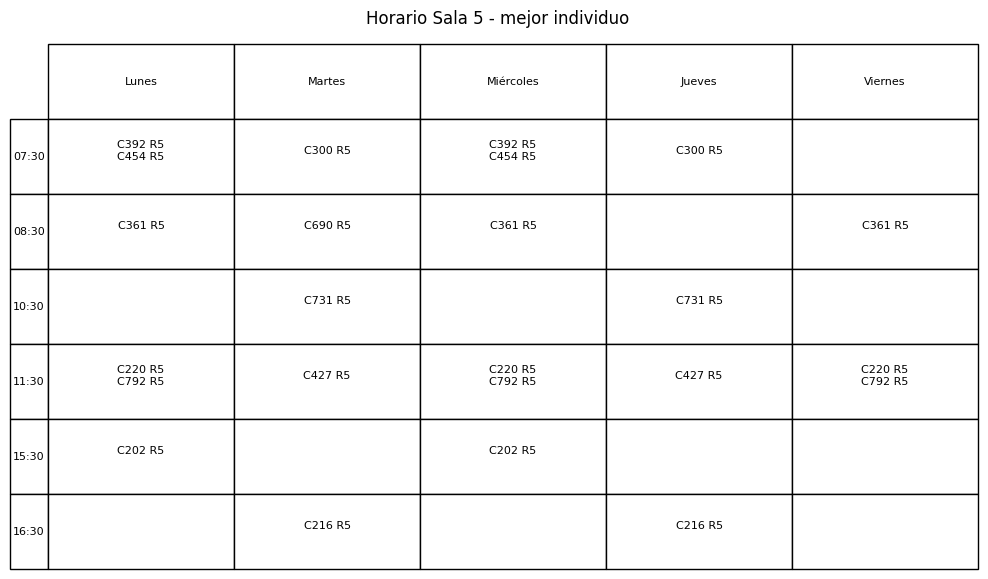

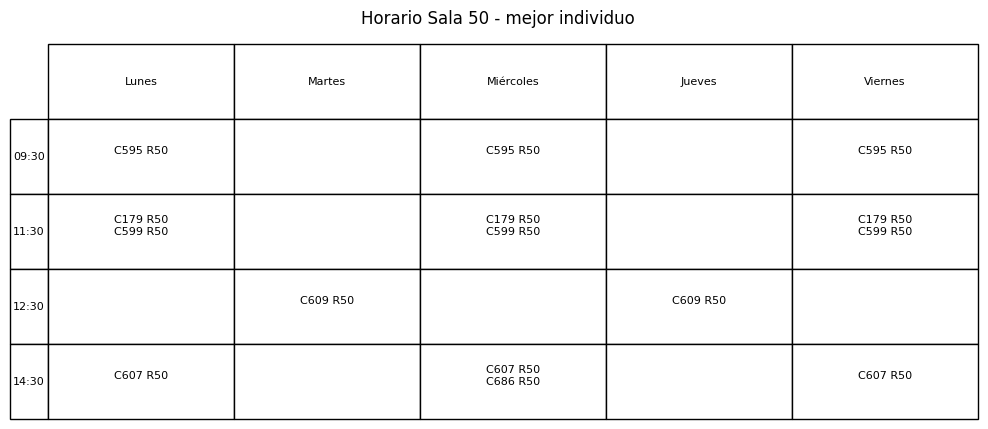

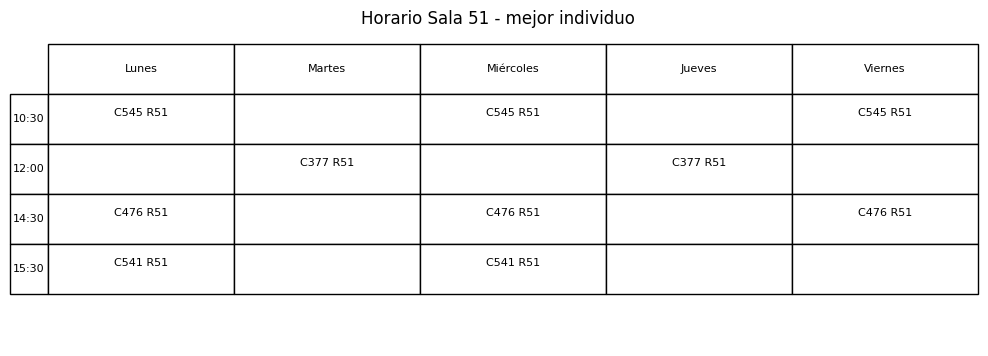

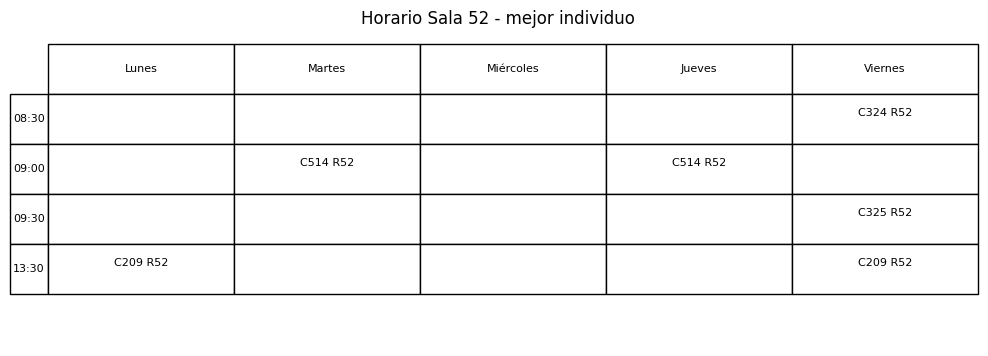

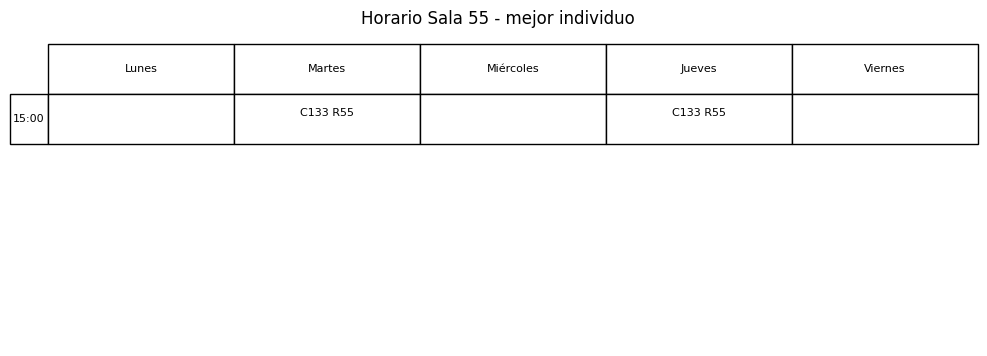

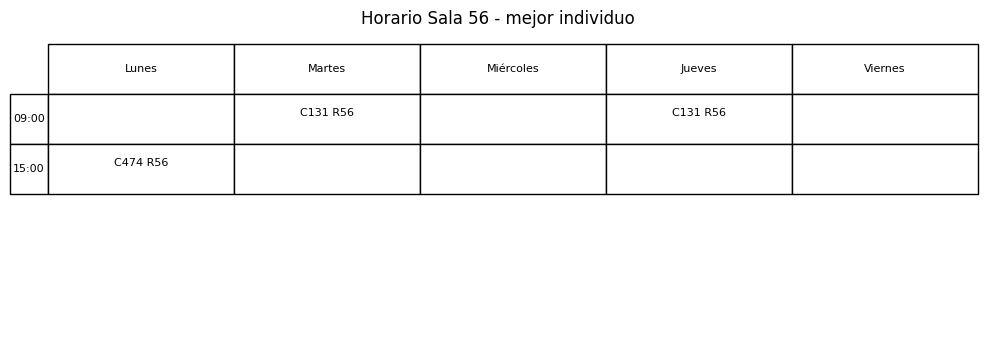

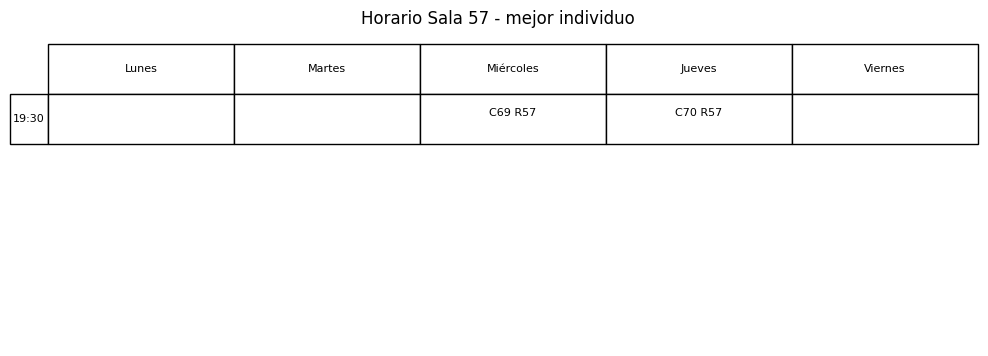

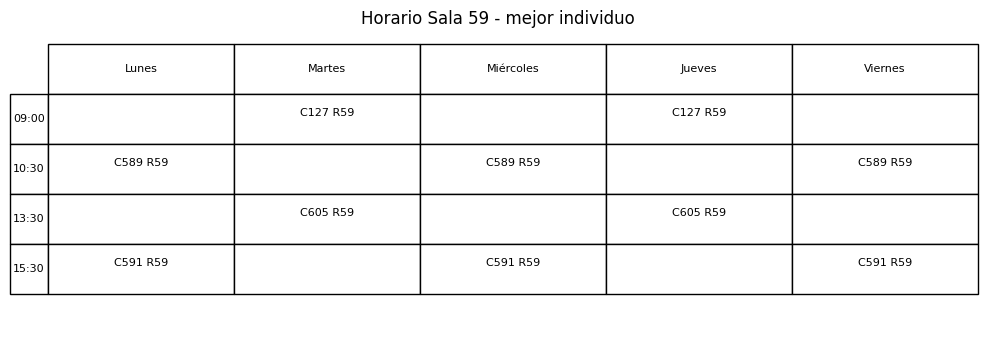

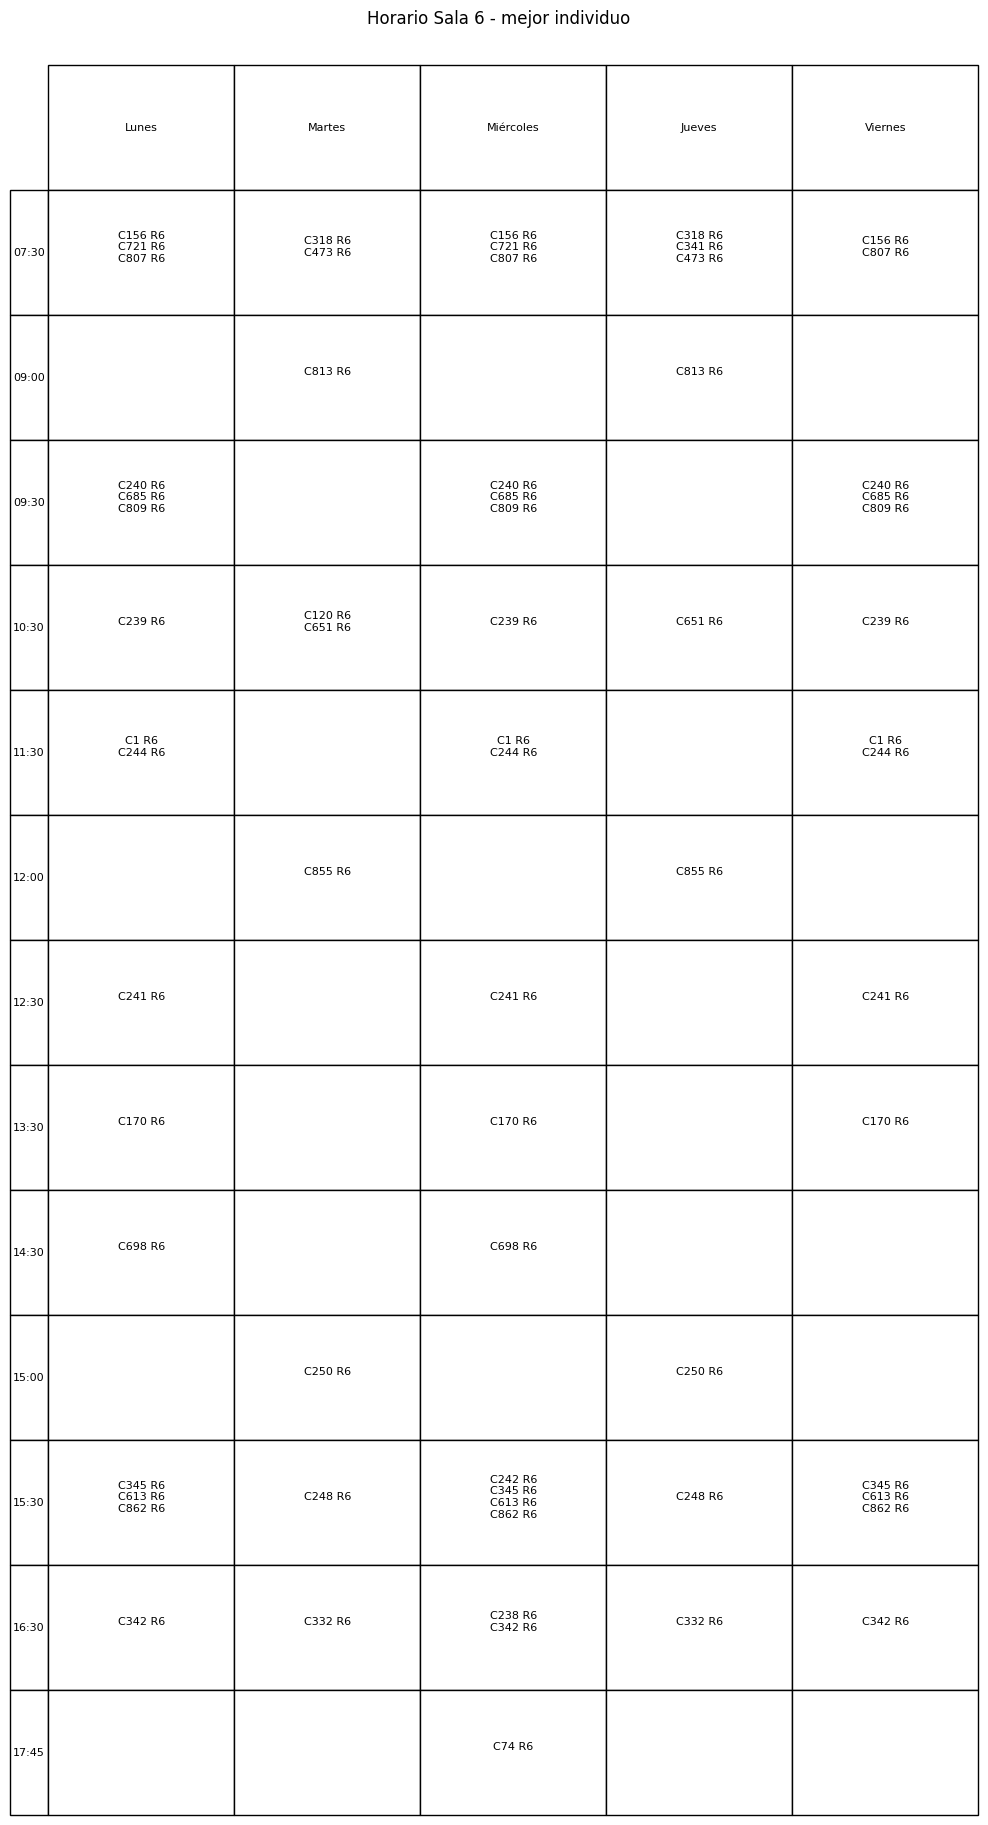

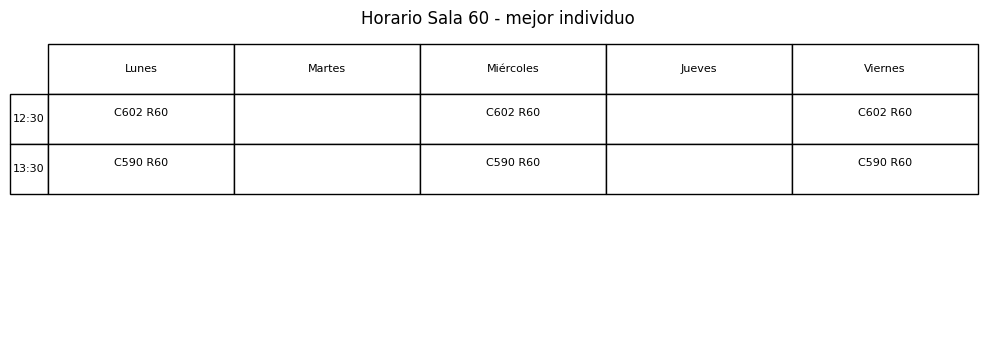

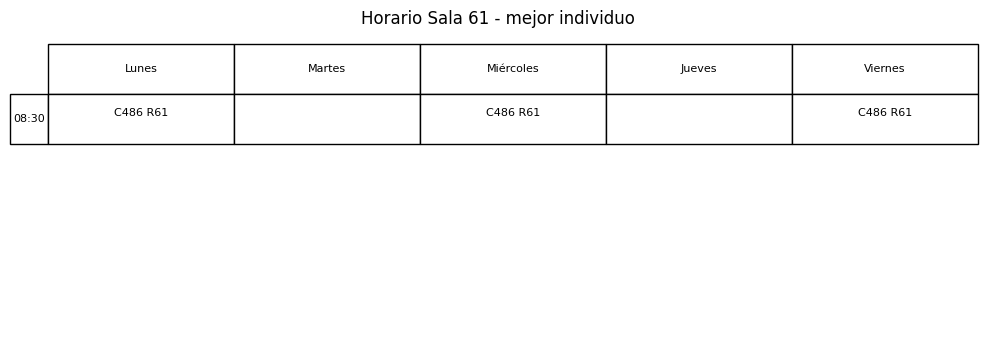

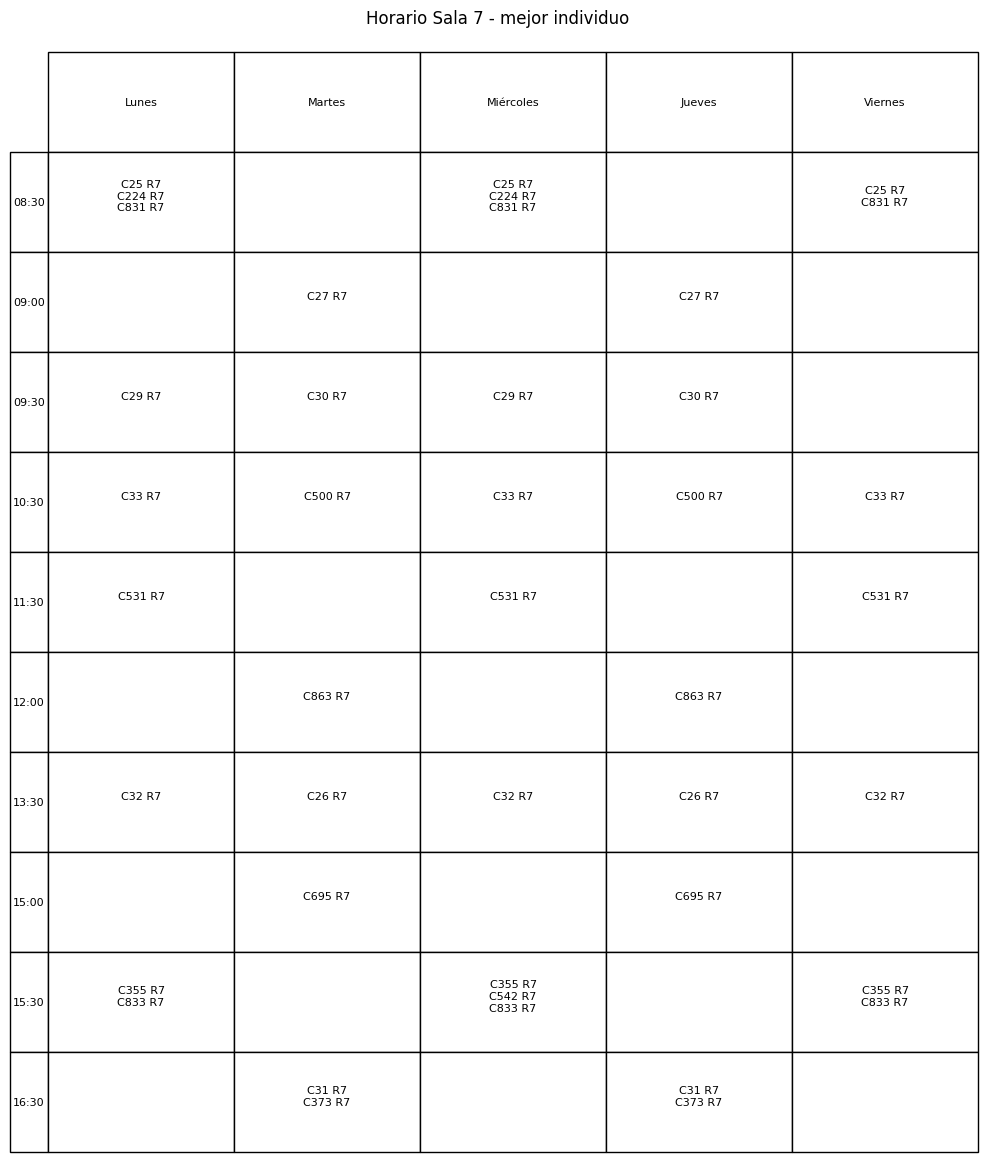

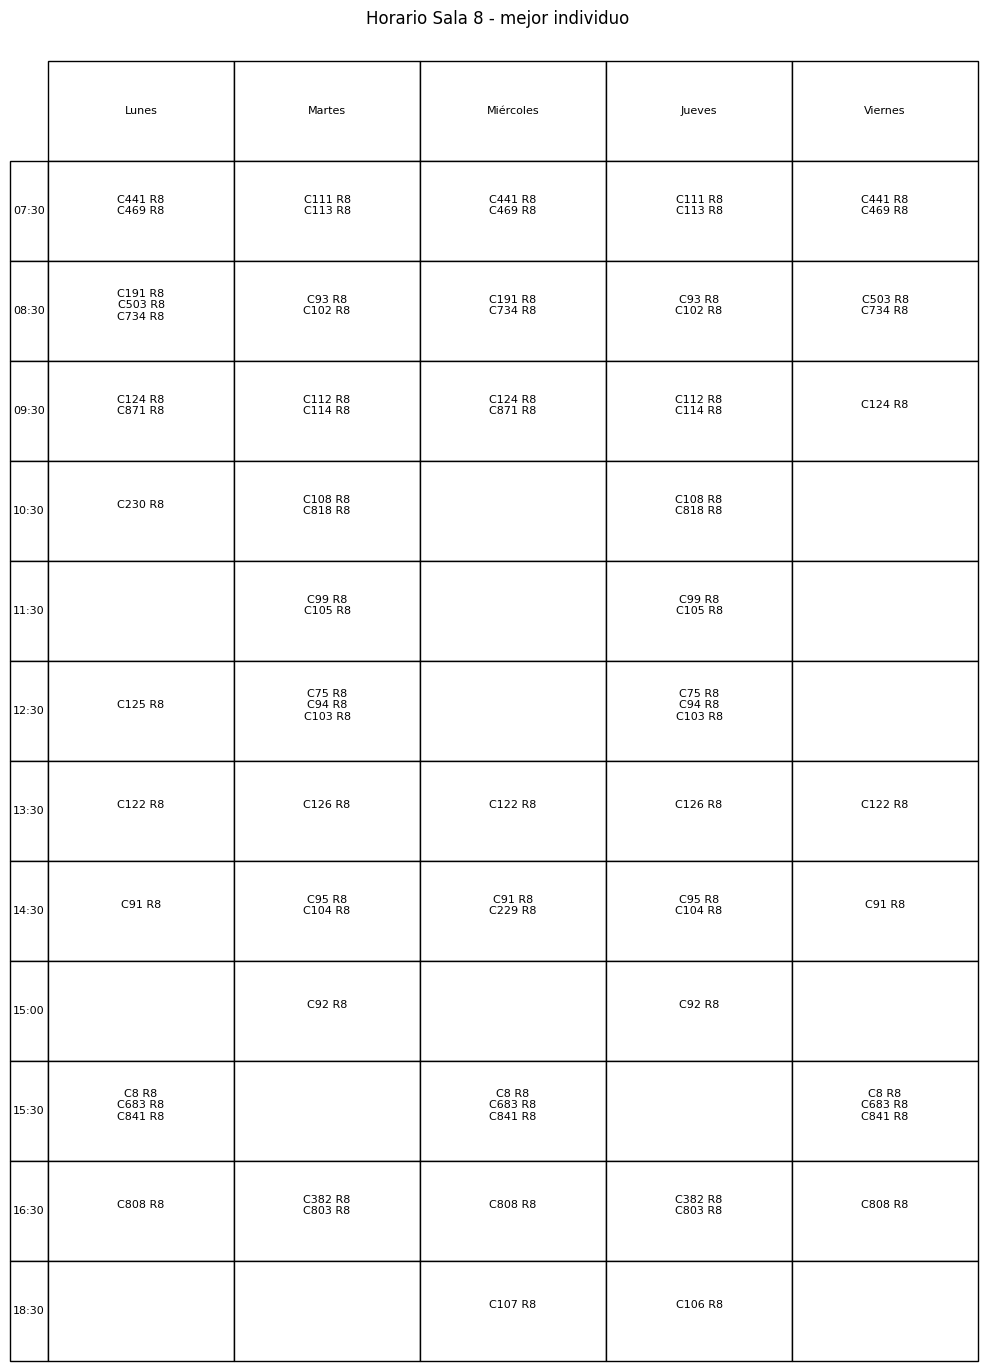

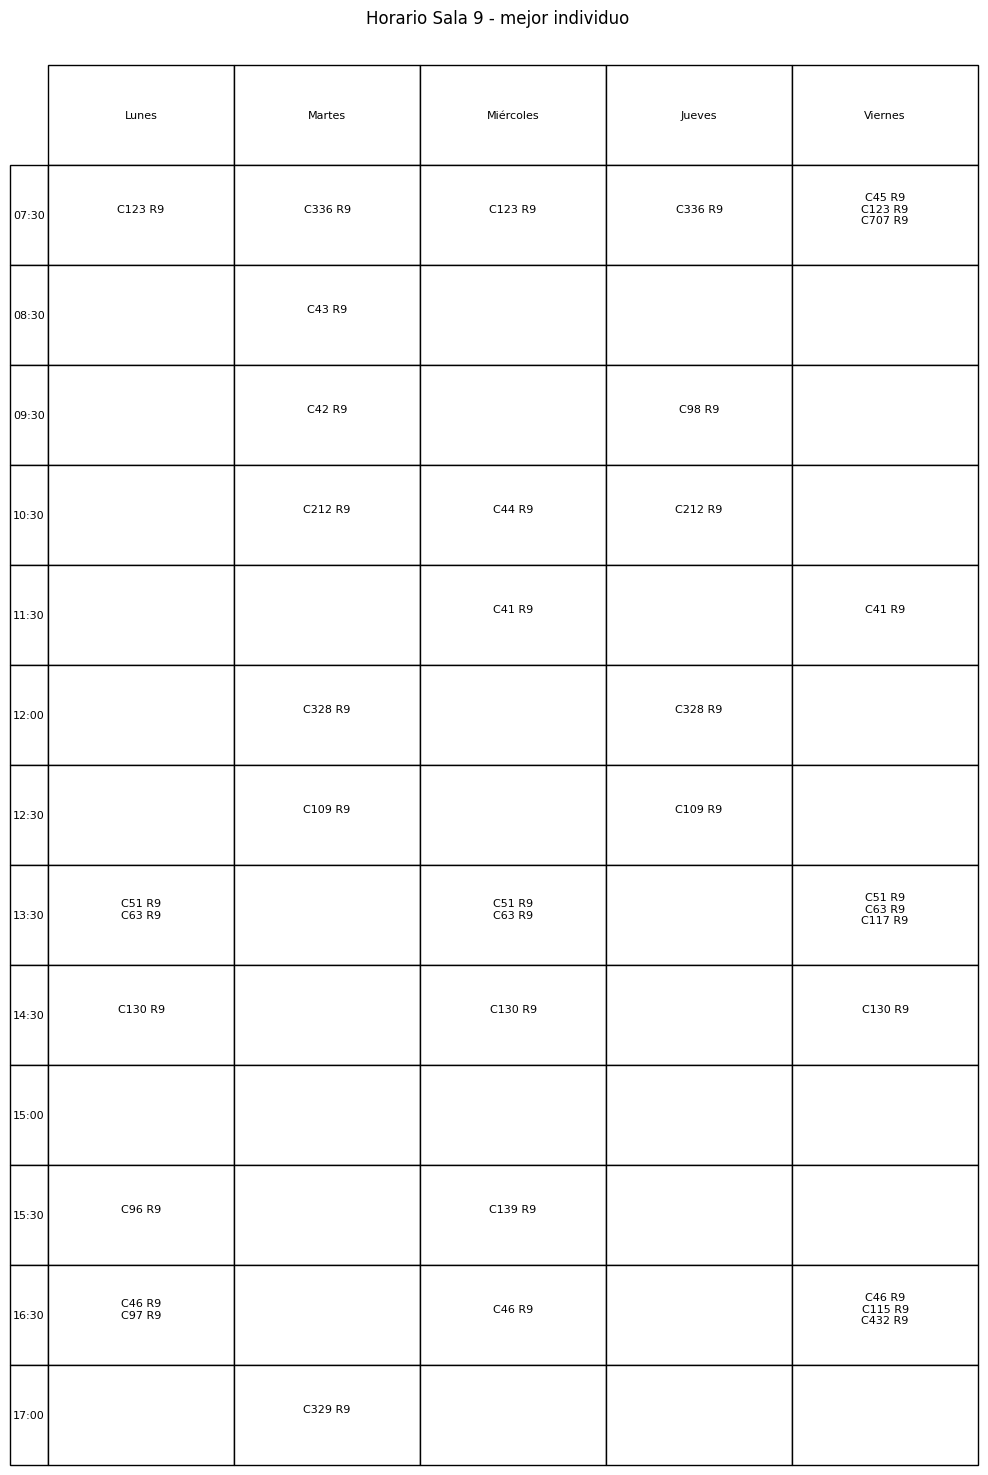

In [18]:
# ---------- Visualización por sala ----------
import matplotlib.pyplot as plt

placement = build_placement(best)
# Recolectar todas las salas usadas en la mejor solución
salas_usadas = set(val['room'] for val in placement.values() if val['room'] is not None)

# Considerar días de lunes a viernes
days_use = DIAS[:5]

for room_id in sorted(salas_usadas):
    # Filtrar clases asignadas a esta sala
    clases_sala = {cid: val for cid, val in placement.items() if val['room'] == room_id}

    # Recolectar todos los start times de esta sala
    starts_set = set(val['time']['start'] for val in clases_sala.values())
    starts_sorted = sorted(list(starts_set))
    row_labels = [to_hhmm_from_slot(s) for s in starts_sorted]

    # Crear tabla vacía
    tabla = pd.DataFrame("", index=row_labels, columns=days_use)

    # Llenar tabla
    for cid, val in clases_sala.items():
        time_obj = val['time']
        label = f"C{cid} R{room_id}"
        for i, bit in enumerate(time_obj['days_bin']):
            if bit == '1' and DIAS[i] in days_use:
                start_label = to_hhmm_from_slot(time_obj['start'])
                if start_label not in tabla.index:
                    tabla.loc[start_label] = ""
                tabla.loc[start_label, DIAS[i]] += label + "\n"

    # Dibujar tabla
    fig, ax = plt.subplots(figsize=(12, max(4, len(tabla)/2)))
    ax.axis('off')

    # Dibujar tabla centrada solo horizontalmente
    table = ax.table(cellText=tabla.values, rowLabels=tabla.index, colLabels=tabla.columns,
                    cellLoc='center', rowLoc='center', loc='upper center')  # cambiar loc a 'upper center'

    # Centrar texto dentro de cada celda
    for key, cell in table.get_celld().items():
        cell.set_text_props(va='center', ha='center')

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5 * max(1, max(len(str(cell.get_text().get_text()).split("\n")) for cell in table.get_celld().values())))

    fig.suptitle(f"Horario Sala {room_id} - mejor individuo", fontsize=12, y=0.95)  # y controla altura del título
    plt.show()

